# Introduction
Analyzing the IMDB Movie dataset, I'm going to  predict how successful a movie is using the adjusted revenue (for inflation) as the measure of success. With nearly 11,000 movies and twenty variables, I should be able to choose features correlated with the revenue to create a good model.

In [146]:
# Set up & handling the data
import os
os.chdir('/Users/sophiaperides/Desktop/Thinkful')
import csv
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings(action="ignore")

# Cleaning the data
import re

# Transforming the data
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats.mstats import winsorize
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn import ensemble   # we'll use ensemble random forests


# Running the models
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
# from sklearn.metrics import precision_score, recall_score, accuracy_score

#Statistics
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt


# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

## Cleaning

There are 6,016 rows with an adjused revenue of \\$0. I'm going to remove these rows as they do not contain the target variable. Of the remaining rows, there are nearly one hundred with adjusted revenue under \\$10,000. I will investigate these individual movies and update those that are incorrect and confirm the accuracy of the rest.

Columns homepage, director, cast, keywords, tagline, and production_companies are missing values. For the homepage column, I will assume a missing value indicates that a movie does not have a homepage. One movie is missing the director and five movies are missing the cast, so I will look up this information and manually add it to the dataset. I will set cells missing values for keywords, tagline, and production companies to 'Unknown'. Additionally, popularity, budget, revenue, runtime, and votecount have clear high outliers. I'm going to take a look at these columns and see if I can derive what may be going on.

In [2]:
movies = pd.read_csv('IMDBMovies.csv')
movies = pd.DataFrame(movies)
print(movies.columns)
print('\n', movies.describe())
movies.info()

Index(['id', 'imdb_id', 'popularity', 'budget', 'revenue', 'original_title',
       'cast', 'homepage', 'director', 'tagline', 'keywords', 'overview',
       'runtime', 'genres', 'production_companies', 'release_date',
       'vote_count', 'vote_average', 'release_year', 'budget_adj',
       'revenue_adj'],
      dtype='object')

               id  popularity        budget        revenue   runtime  \
count  10866.000   10866.000     10866.000      10866.000 10866.000   
mean   66064.177       0.646  14625701.094   39823319.793   102.071   
std    92130.137       1.000  30913213.831  117003486.582    31.381   
min        5.000       0.000         0.000          0.000     0.000   
25%    10596.250       0.208         0.000          0.000    90.000   
50%    20669.000       0.384         0.000          0.000    99.000   
75%    75610.000       0.714  15000000.000   24000000.000   111.000   
max   417859.000      32.986 425000000.000 2781505847.000   900.000   

       vote_count  vote_ave

In [3]:
pd.options.display.max_columns
movies[movies['revenue_adj'] == 0 ].shape
movies = movies[movies.revenue_adj != 0]
print(movies.describe())
movies.info()
movies.head()

              id  popularity        budget        revenue  runtime  \
count   4850.000    4850.000      4850.000       4850.000 4850.000   
mean   44575.001       1.045  29569700.632   89220658.325  107.965   
std    72361.406       1.357  40513434.965  162068389.382   21.113   
min        5.000       0.001         0.000          2.000   15.000   
25%     8286.000       0.388   1700000.000    7708081.250   95.000   
50%    12154.500       0.680  15000000.000   31826540.000  104.000   
75%    43956.500       1.210  40000000.000   99918234.250  117.000   
max   417859.000      32.986 425000000.000 2781505847.000  705.000   

       vote_count  vote_average  release_year    budget_adj    revenue_adj  
count    4850.000      4850.000      4850.000      4850.000       4850.000  
mean      436.216         6.149      2000.922  35161017.182  115077354.868  
std       806.416         0.799        11.569  43756717.053  198841916.046  
min        10.000         2.100      1960.000         0.000  

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.986,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/2015,5562,6.500,2015,137999939.300,1392445893.000
1,76341,tt1392190,28.420,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/2015,6185,7.100,2015,137999939.300,348161292.500
2,262500,tt2908446,13.113,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/2015,2480,6.300,2015,101199955.500,271619025.400
3,140607,tt2488496,11.173,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/2015,5292,7.500,2015,183999919.000,1902723130.000
4,168259,tt2820852,9.335,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/2015,2947,7.300,2015,174799923.100,1385748801.000


97


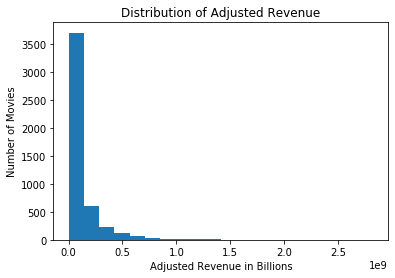

In [4]:
print(len(movies.loc[movies['revenue_adj'] < 10000].sort_values('revenue_adj')))
pd.options.display.max_columns = None
movies.loc[movies['revenue_adj'] < 10000].sort_values('revenue_adj')

# Updating incorrect entries in target variable.
movies.at[5067, 'revenue_adj'] = 2944752
movies.at[8142, 'revenue_adj'] = 2122561
movies.at[3239, 'revenue_adj'] = 3800000
movies.at[5162, 'revenue_adj'] = 0
movies.at[8523, 'revenue_adj'] = 5600000
movies.at[8226, 'revenue_adj'] = 6858261
movies.at[10307, 'revenue_adj'] = 6265311
movies.at[3283, 'revenue_adj'] = 11500000
movies.at[2252, 'revenue_adj'] = 18000
movies.at[5852, 'revenue_adj'] = 0
movies.at[1380, 'revenue_adj'] = 4000000
movies.at[7158, 'revenue_adj'] = 12313323
movies.at[8328, 'revenue_adj'] = 9200000
movies.at[3853, 'revenue_adj'] = 0
movies.at[10607, 'revenue_adj'] = 11800000
movies.at[8235, 'revenue_adj'] = 6858261
movies.at[2519, 'revenue_adj'] = 13042112
movies.at[9109, 'revenue_adj'] = 15923122
movies.at[9390, 'revenue_adj'] = 13878334
movies.at[10294, 'revenue_adj'] = 15935068
movies.at[8125, 'revenue_adj'] = 16115878
movies.at[10050, 'revenue_adj'] = 16324573
movies.at[5060, 'revenue_adj'] = 4750602
movies.at[4675, 'revenue_adj'] = 30932113
movies.at[10045, 'revenue_adj'] = 22305841
movies.at[8944, 'revenue_adj'] = 16100000
movies.at[10777, 'revenue_adj'] = 36000000
movies.at[10297, 'revenue_adj'] = 40750000
movies.at[2398, 'revenue_adj'] = 43294943
movies.at[8599, 'revenue_adj'] = 44847000
movies.at[9401, 'revenue_adj'] = 46432000
movies.at[7506, 'revenue_adj'] = 48377000
movies.at[10236, 'revenue_adj'] = 63398000
movies.at[7901, 'revenue_adj'] = 67169000
movies.at[1900, 'revenue_adj'] = 84000
movies.at[6011, 'revenue_adj'] = 599840
movies.at[5785, 'revenue_adj'] = 1471106
movies.at[5777, 'revenue_adj'] = 127257
movies.at[9332, 'revenue_adj'] = 124885000
movies.at[2618, 'revenue_adj'] = 6552255
movies.at[1733, 'revenue_adj'] = 404099
movies.at[6707, 'revenue_adj'] = 155760000
movies.at[5834, 'revenue_adj'] = 228004
movies.at[3698, 'revenue_adj'] = 213000000
movies.at[4970, 'revenue_adj'] = 296338000
movies.at[9992, 'revenue_adj'] = 333780000
movies.at[9580, 'revenue_adj'] = 444378
movies.at[4682, 'revenue_adj'] = 498.616
movies.at[5669, 'revenue_adj'] = 5990.997
movies.at[4665, 'revenue_adj'] = 712216
movies.at[5637, 'revenue_adj'] = 757251
movies.at[4667, 'revenue_adj'] = 1026.674
movies.at[2273, 'revenue_adj'] = 1279.000
movies.at[3581, 'revenue_adj'] = 1926
movies.at[4909, 'revenue_adj'] = 1632
movies.at[4668, 'revenue_adj'] = 1938
movies.at[4611, 'revenue_adj'] = 2521
movies.at[1156, 'revenue_adj'] = 2496.157
movies.at[1033, 'revenue_adj'] = 2756
movies.at[4495, 'revenue_adj'] = 3003
movies.at[4591, 'revenue_adj'] = 3010
movies.at[3621, 'revenue_adj'] = 3358
movies.at[3692, 'revenue_adj'] = 3838
movies.at[7602, 'revenue_adj'] = 5665
movies.at[2078, 'revenue_adj'] = 3826
movies.at[5684, 'revenue_adj'] = 4187
movies.at[378, 'revenue_adj'] = 4444
movies.at[294, 'revenue_adj'] = 4505
movies.at[5918, 'revenue_adj'] = 4916

plt.hist(x=movies['revenue_adj'], bins=20)
plt.title('Distribution of Adjusted Revenue')
plt.xlabel('Adjusted Revenue in Billions')
plt.ylabel('Number of Movies')
plt.show()

## Genres Variable
The contents in the genres column contain multiple genres separated by the '|' symbol. I'm going to separate the genres in each cell, find all unique values, and create a dummy column for each genre. If a movie contains that genre in its description, the column will have the value one in the corresponding cell. Otherwise, the genre column for that movie will contain a zero.

In [5]:

# Create a list of the genres

Genres = movies.genres.unique()
genres = []
flatten_genres = []

for list_of_genres in Genres:
    movies_genres = list_of_genres.split('|')
    genres.append(movies_genres)
    for i in range(len(genres)): #Traversing through the main list
        for j in range (len(genres[i])): #Traversing through each sublist
            flatten_genres.append(genres[i][j]) #Appending elements into our flat_list

unique_genres = set(flatten_genres)
print(unique_genres)

# Creating dummy columns for each genre
for genre in unique_genres:
    movies[genre] = 0 

{'Music', 'Drama', 'Comedy', 'Action', 'Crime', 'Horror', 'Adventure', 'Mystery', 'Documentary', 'Foreign', 'TV Movie', 'Romance', 'Family', 'History', 'Western', 'Fantasy', 'War', 'Science Fiction', 'Animation', 'Thriller'}


In [6]:
# Populating each genre column
def populating_genres(df, genre_list):
    for i, row in df.iterrows():
        movies_genres = df.loc[i]['genres']
        for genre in genre_list:
            if genre in movies_genres:
                df.at[i, genre] = 1
    return df

populating_genres(movies, unique_genres)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,Music,Drama,Comedy,Action,Crime,Horror,Adventure,Mystery,Documentary,Foreign,TV Movie,Romance,Family,History,Western,Fantasy,War,Science Fiction,Animation,Thriller
0,135397,tt0369610,32.986,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,monster|dna|tyrannosaurus rex|velociraptor|island,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/2015,5562,6.500,2015,137999939.300,1392445893.000,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
1,76341,tt1392190,28.420,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,future|chase|post-apocalyptic|dystopia|australia,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/2015,6185,7.100,2015,137999939.300,348161292.500,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
2,262500,tt2908446,13.113,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,based on novel|revolution|dystopia|sequel|dyst...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/2015,2480,6.300,2015,101199955.500,271619025.400,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
3,140607,tt2488496,11.173,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,android|spaceship|jedi|space opera|3d,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/2015,5292,7.500,2015,183999919.000,1902723130.000,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0
4,168259,tt2820852,9.335,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,car race|speed|revenge|suspense|car,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/2015,2947,7.300,2015,174799923.100,1385748801.000,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,281957,tt1663202,9.111,135000000,532950503,The Revenant,Leonardo DiCaprio|Tom Hardy|Will Poulter|Domhn...,http://www.foxmovies.com/movies/the-revenant,Alejandro González Iñárritu,"(n. One who has returned, as if from the dead.)",father-son relationship|rape|based on novel|mo...,"In the 1820s, a frontiersman, Hugh Glass, sets...",156,Western|Drama|Adventure|Thriller,Regency Enterprises|Appian Way|CatchPlay|Anony...,12/25/2015,3929,7.200,2015,124199945.400,490314247.000,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
6,87101,tt1340138,8.654,155000000,440603537,Terminator Genisys,Arnold Schwarzenegger|Jason Clarke|Emilia Clar...,http://www.terminatormovie.com/,Alan Taylor,Reset the future,saving the world|artificial intelligence|cybor...,"The year is 2029. John Connor, leader of the r...",125,Science Fiction|Action|Thriller|Adventure,Paramount Pictures|Skydance Productions,6/23/2015,2598,5.800,2015,142599937.300,405355075.700,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
7,286217,tt3659388,7.667,108000000,595380321,The Martian,Matt Damon|Jessica Chastain|Kristen Wiig|Jeff ...,http://www.foxmovies.com/movies/the-martian,Ridley Scott,Bring Him Home,based on novel|mars|nasa|isolation|botanist,"During a manned mission to Mars, Astronaut Mar...",141,Drama|Adventure|Science Fiction,Twentieth Century Fox Film 

## Cast Variable

Each cell in the cast column has up to five actors and/or actresses central to the movie. I have found a list of the top one hundred movie stars from 1960, the year of the oldest movie, and to make use of this variable, I will create a new feature called 'top_100_actors' which holds the number of actors each movie has from this list. I would expect to see that movies with more stars than others would be more successful.

The list I used had replaced many letters containing accents (ex. á, å, etc.) with incorrect characters, so I used a list comprehension to filter these names and updated them directly in the csv.

In [7]:
# Adding the missing top five cast members
movies[movies['cast'].isnull()]
movies.at[1088, 'cast'] = 'Vivian Maier|John Maloof|Daniel Arnaud|Simone Amédé|Maren Baylaender'
movies.at[4127, 'cast'] = 'Belladonna|Marlon Brando|Elton John|Julia Louis-Dreyfus|Madonna'
movies.at[4889, 'cast'] = 'Jay Bastian|Joe Biden|Cait Brasel|Gene Burris Jr.|Dinesh D\'Souza'
movies.at[7813, 'cast'] = 'Dylan Avery|Mahmoud Ahmad|Ahmed Al-Ghamdi|Hamza Al-Ghamdi|Saeed Al-Ghamdi'
movies.at[9564, 'cast'] = 'Christie Brinkley|David Brinkley|Pope John Paul II|Dan Rather|Cheryl Tiegs'
movies[movies['cast'].isnull()]

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,Music,Drama,Comedy,Action,Crime,Horror,Adventure,Mystery,Documentary,Foreign,TV Movie,Romance,Family,History,Western,Fantasy,War,Science Fiction,Animation,Thriller


In [8]:
# Splitting the cast information into lists
movies['cast'] = movies['cast'].apply(lambda x: x.split('|'))

In [9]:
## Create a list of actors

Cast = movies.cast # a list of the list of cast members in each movie
cast = [] # 
flatten_cast = []

for list_of_actors in Cast: 
    cast.append(list_of_actors)
    for i in range(len(cast)): #Traversing through the main list
        for j in range (len(cast[i])): #Traversing through each sublist
            flatten_cast.append(cast[i][j]) #Appending elements into our flat_list

unique_actors = set(flatten_cast)


In [10]:
# cleaning names - finding actor's names with non-alphanumeric characters
unique_actors = list(unique_actors)
print(type(unique_actors)) 
non_alphanumeric = [i for i in unique_actors if not i.lower().replace(" ", "").replace('\'', '').replace('.', '')
                    .replace('-', '').replace(',','').replace('ÃƒÂ¥', 'å').replace('ÃƒÂ¡', 'á').replace('ÃƒÂ\xad', 'í')
                    .isalpha()]
print('\n \n Names with non-alphanumeric characters:\n ', non_alphanumeric)

<class 'list'>

 
 Names with non-alphanumeric characters:
  ['50 Cent', 'JōÂ«rōta Kosugi', 'Linh āan PhÃ¡ÂºÂ¡m', 'āềâ€” Thềâ€¹ HÃ¡ÂºÂ£i YÃ¡ÂºÂ¿n', 'Jordi MollÃƒÂ\xa0', 'Ã\xa0Â¸ÂªÃ\xa0Â¸Â£Ã\xa0Â¸Å¾Ã\xa0Â¸â€¡Ã\xa0Â¸Â©Ã\xa0Â¹Å’ Ã\xa0Â¸Å\xa0Ã\xa0Â¸Â²Ã\xa0Â¸â€¢Ã\xa0Â¸Â£Ã\xa0Â¸Âµ', 'Antonio SabÃƒÂ\xa0to, Jr.']


In [11]:
# Importing the top 100 stars and removing 'Actor' and 'Actress' so we just have names in the stars dataframe

top_100_actors = pd.read_csv('top_100_stars.csv')
top_100_actors = pd.DataFrame(top_100_actors)


top_100_actors['Name'] = top_100_actors['Name'].str.replace(' Actor', '')
top_100_actors['Name'] = top_100_actors['Name'].str.replace(' Actress', '')

# Converting the series to a list so we can compare it to the cast lists
top_100_actors = top_100_actors['Name'].tolist()
top_100_actors[:5]

movies['top_100_actors'] = [len(set(i) & set(top_100_actors)) for i in movies['cast']]
print('Number of movies for each number of stars (0-5): \n', movies.top_100_actors.value_counts())

Number of movies for each number of stars (0-5): 
 0    4022
1     679
2     134
3      14
4       1
Name: top_100_actors, dtype: int64


## Tagline Variable
For this variable, I will create a new column called 'tagline_length' for the number of words in the tagline to see if there is any correlation between tagline length and revenue. A cell will contain a zero if there is no taglien, a 1 if there are fewer than six words in the tagline, and a two if there are more, and a two if there are more than six words. My hypothesis is that movies with shorter taglines fare better - short and sweet is key!

In [12]:
movies['tagline_length'] = movies['tagline'].str.count(' ') + 1
movies.tagline_length.fillna(0 , inplace=True)

## Homepage Variable
I will create a dummy variable that reflects whether or not a movie has a homepage. This column will contain a one if a movie has a homepage and a zero if it does not.

In [13]:
movies['homepage_dummy'] = movies['homepage'].apply(lambda x: 0 if pd.isnull(x) else 1)

## Production Companies Variable
I'm not sure yet how to handle this variable, but will fill any empty cells with 'Unknown' for now.

In [14]:
movies['production_companies'] = movies['production_companies'].apply(lambda x: 'Unknown' if pd.isnull(x) else x)
print('There are', len(movies['production_companies'].unique()), 'production companies.')

There are 3683 production companies.


## Keywords Variable
I'm not sure yet how to handle this variable, but will fill any empty cells with 'Unknown' for now.

In [15]:
movies['keywords'] = movies['keywords'].apply(lambda x: 'Unknown' if pd.isnull(x) else x)
print('There are', len(movies[movies['keywords'] == 'Unknown']), 'movies with no keywords.')

There are 235 movies with no keywords.


## Director Variable
One movie is missing its director, so I will manually add it.

In [16]:
movies.director.isnull()
movies.at[1088, 'director'] = 'Aziz Mirza'
print('There are', len(movies.director.unique()), 'unique directors.')

There are 2134 unique directors.


## Correlation Matrix
Our first look at the correlation matrix provides some insight into the relationships between the variables and our arget, the adjusted revenue. There are strong relationships between budget and popularity which is intuitive, but there's quite a strong correlation between vote count, stronger even than the average vote which is interesting. Vote count and popularity (the average number of visits the IMDB page receives per week) are strongly correlated so I'm going to combine them into a single feature. Family and Animation genres have a fairly strong correlation at 0.516, so I'll combine them as well.

The features I'll start with are vc_pop (the combination of vote_count and popularity), budget_adj, runtime, vote_average, number_of_stars, and Adventure.

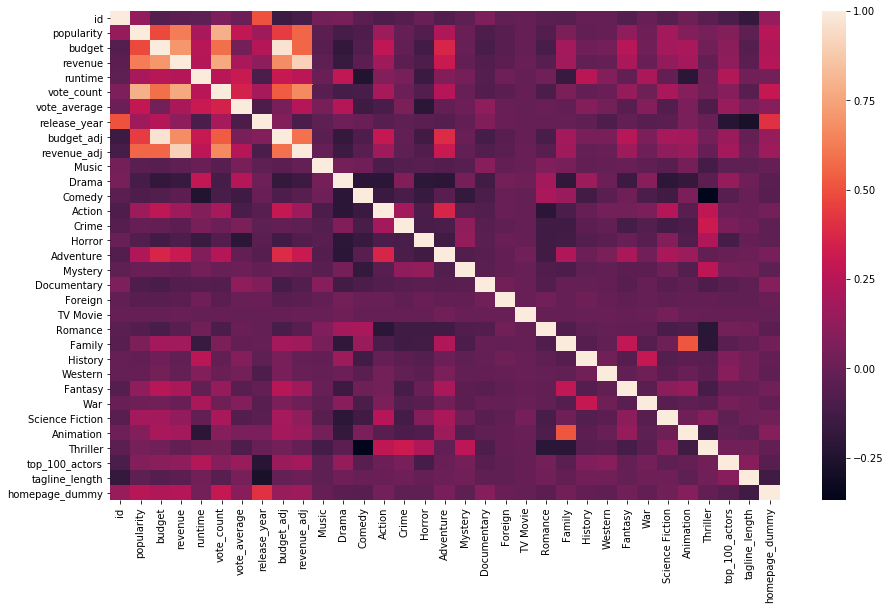

In [17]:
plt.figure(figsize=(15,9))
sns.heatmap(movies.corr())

In [18]:
movies.corr()

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj,Music,Drama,Comedy,Action,Crime,Horror,Adventure,Mystery,Documentary,Foreign,TV Movie,Romance,Family,History,Western,Fantasy,War,Science Fiction,Animation,Thriller,top_100_actors,tagline_length,homepage_dummy
id,1.000,0.140,-0.068,-0.041,-0.031,0.070,0.008,0.507,-0.146,-0.116,0.035,0.045,-0.045,-0.089,-0.060,-0.001,-0.074,-0.033,0.067,-0.021,-0.006,-0.042,-0.048,-0.007,-0.013,-0.065,0.001,-0.055,0.013,-0.038,-0.099,-0.176,0.148
popularity,0.140,1.000,0.481,0.629,0.201,0.788,0.289,0.170,0.440,0.562,-0.044,-0.112,-0.085,0.162,-0.005,-0.073,0.227,0.004,-0.086,-0.050,-0.008,-0.072,0.064,-0.020,-0.005,0.127,0.012,0.185,0.084,0.047,0.083,-0.036,0.248
budget,-0.068,0.481,1.000,0.704,0.247,0.586,0.037,0.238,0.964,0.561,-0.053,-0.183,-0.078,0.278,-0.019,-0.127,0.369,-0.001,-0.101,-0.051,-0.009,-0.102,0.188,0.021,0.037,0.249,0.030,0.183,0.200,0.032,0.108,-0.058,0.223
revenue,-0.041,0.629,0.704,1.000,0.238,0.764,0.207,0.121,0.674,0.904,-0.033,-0.163,-0.041,0.177,-0.041,-0.090,0.306,-0.018,-0.071,-0.040,-0.004,-0.057,0.180,-0.022,-0.012,0.204,0.005,0.132,0.186,-0.016,0.126,-0.037,0.237
runtime,-0.031,0.201,0.247,0.238,1.000,0.252,0.308,-0.100,0.304,0.264,0.005,0.280,-0.243,0.082,0.050,-0.156,0.076,0.039,-0.067,0.022,-0.013,0.028,-0.163,0.259,0.082,-0.025,0.212,-0.016,-0.211,0.017,0.234,0.031,0.035
vote_count,0.070,0.788,0.586,0.764,0.252,1.000,0.351,0.197,0.533,0.666,-0.053,-0.114,-0.105,0.196,0.009,-0.072,0.240,-0.002,-0.069,-0.041,-0.007,-0.091,0.060,-0.017,0.002,0.140,0.014,0.199,0.093,0.032,0.094,-0.055,0.297
vote_average,0.008,0.289,0.037,0.207,0.308,0.351,1.000,-0.095,0.049,0.243,0.052,0.242,-0.138,-0.102,0.064,-0.210,-0.020,0.007,0.129,-0.002,-0.010,0.004,-0.019,0.087,0.037,-0.053,0.088,-0.068,0.059,-0.086,0.151,0.047,0.100
release_year,0.507,0.170,0.238,0.121,-0.100,0.197,-0.095,1.000,0.083,-0.100,-0.036,0.019,0.003,-0.054,-0.036,-0.044,-0.058,-0.019,0.076,0.004,-0.006,-0.011,-0.009,-0.036,-0.089,-0.020,-0.047,-0.047,0.056,-0.002,-0.220,-0.274,0.410
budget_adj,-0.146,0.440,0.964,0.674,0.304,0.533,0.049,0.083,1.000,0.593,-0.043,-0.179,-0.089,0.298,-0.015,-0.132,0.388,0.003,-0.112,-0.055,-0.009,-0.101,0.187,0.053,0.050,0.250,0.057,0.194,0.185,0.038,0.158,-0.015,0.149
revenue_adj,-0.116,0.562,0.561,0.904,0.264,0.666,0.243,-0.100,0.593,1.000,-0.013,-0.145,-0.048,0.174,-0.036,-0.082,0.306,-0.023,-0.076,-0.042,-0.004,-0.050,0.167,-0.010,0.001,0.174,0.019,0.125,0.157,-0.007,0.187,0.011,0.165


## Visualizing the relationships between variables and the target

The graphs below give a nice visual of variables with the highest correlations of the target. While it's interesting that there's a higher correlation between vote_count and popularity than vote_average and popularity, I imagine this is a case of 'any press is good press' - more individuals voting on a movie indicates that more individuals have seen and spent money on the movie.

Unsurprisingly, movies with a higher adjusted budjet tend to have higher adjusted revenue. It stands to reason that the higher a movie's budget, the more opportunies and the higher the quality (production, cast, etc.) the movie can have.

Finally, we can see there's a slight increase in the adjusted revenue as the number of actors in the top_100_actors list increases.

<Figure size 144x216 with 0 Axes>

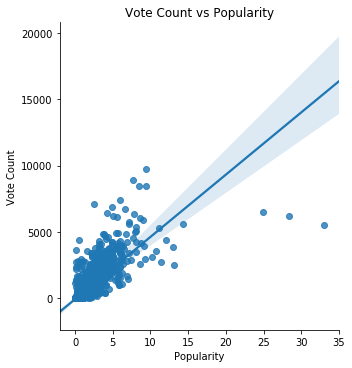

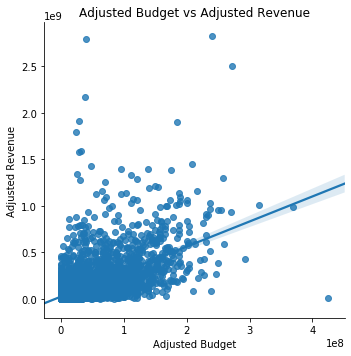

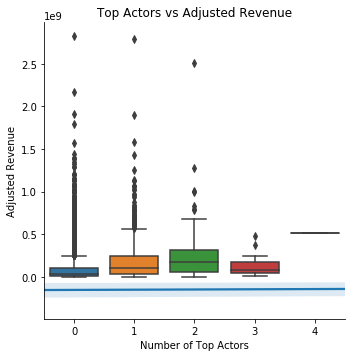

In [20]:
plt.figure(figsize=(2,3))
sns.lmplot(x='popularity', y='vote_count', data=movies)
plt.title('Vote Count vs Popularity')
plt.xlabel('Popularity')
plt.ylabel('Vote Count')


sns.lmplot(x='budget_adj', y='revenue_adj', data=movies)
plt.title('Adjusted Budget vs Adjusted Revenue')
plt.xlabel('Adjusted Budget')
plt.ylabel('Adjusted Revenue')

sns.lmplot(x='runtime', y='revenue_adj', data=movies)
plt.title('Runtime vs Adjusted Revenue')
plt.xlabel('Runtime in Minutes')
plt.ylabel('Adjusted Revenue')

sns.boxplot(x='top_100_actors', y='revenue_adj', data=movies)
plt.title('Top Actors vs Adjusted Revenue')
plt.xlabel('Number of Top Actors')
plt.ylabel('Adjusted Revenue')
plt.show()

In [21]:
movies['vc_pop'] = movies['vote_count'] * movies['popularity']
corr_mat = movies.corr().loc[:, ["revenue_adj"]].sort_values(by='revenue_adj', ascending=False)
corr_mat

,revenue_adj
revenue_adj,1.000
revenue,0.904
vote_count,0.666
budget_adj,0.593
popularity,0.562
budget,0.561
vc_pop,0.478
Adventure,0.306
runtime,0.264
vote_average,0.243


## Testing for Outliers and Normality
The Jarque Bera and Normality tests provide very large t-values and very small p-values, confirming that our variables are not normal.

A note on outliers: the extreme values in vc_pop seem to be legitimate - neither the vote_count nor the popularity appear to be errors. Additionally, I've confirmed the extreme values in budget_adj for the movies with the ten highest budgets.

In [22]:
# Testing for Normality
features_to_test = features_to_test = ['revenue_adj','vc_pop', 'budget_adj', 'runtime', 'vote_average', 'top_100_actors', 'tagline_length']

# Now run each and one of the featues in above list. Locate the features in your data and calculate the statistics. 
for feat in features_to_test:
    jb_stats = stats.jarque_bera(movies[feat])
    norm_stats = stats.normaltest(movies[feat])
    
    print("Testing for normality on {}:".format(feat))
    print('Jarque-Bera test statistics for', feat, 'is {0} and p value is {1}'.format(jb_stats[0], jb_stats[1]))
    print('Normality test statistics for', feat, 'is {0} and p value is {1}\n'.format(norm_stats[0], norm_stats[1]))


Testing for normality on revenue_adj:
Jarque-Bera test statistics for revenue_adj is 226984.8058942199 and p value is 0.0
Normality test statistics for revenue_adj is 4521.801782675905 and p value is 0.0

Testing for normality on vc_pop:
Jarque-Bera test statistics for vc_pop is 27345131.383749064 and p value is 0.0
Normality test statistics for vc_pop is 9645.87772348386 and p value is 0.0

Testing for normality on budget_adj:
Jarque-Bera test statistics for budget_adj is 10959.419887756596 and p value is 0.0
Normality test statistics for budget_adj is 2133.926912739724 and p value is 0.0

Testing for normality on runtime:
Jarque-Bera test statistics for runtime is 3797640.9538830956 and p value is 0.0
Normality test statistics for runtime is 5921.175938826389 and p value is 0.0

Testing for normality on vote_average:
Jarque-Bera test statistics for vote_average is 112.99050060716442 and p value is 0.0
Normality test statistics for vote_average is 102.28513371965839 and p value is 6.1

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


revenue_adj Data isn't positive.

 Outlier Visualization for revenue_adj feature. 







'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


NameError: name 'bc_feature' is not defined

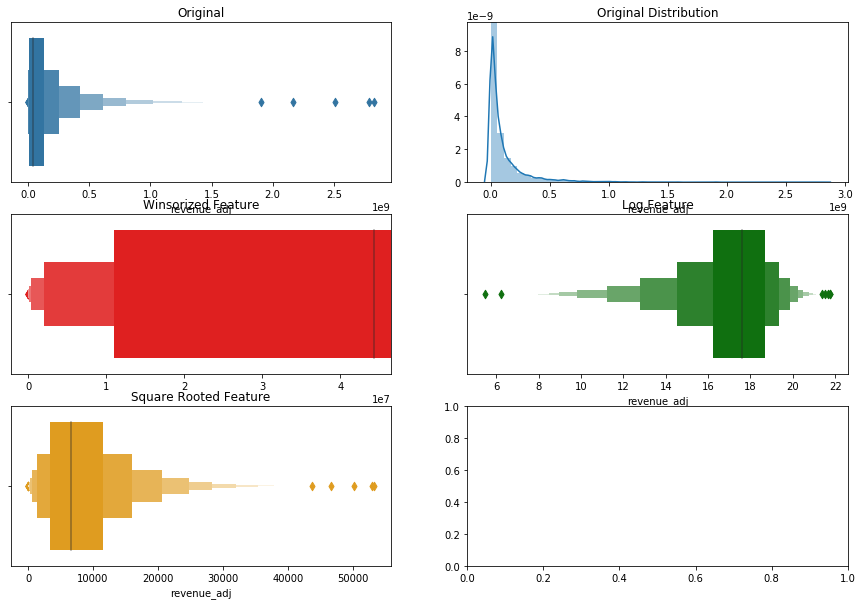

In [23]:
# Specify a list with features we want to test for normality. 
# Visuals for outliers and normality
features_to_test = ['revenue_adj','vc_pop', 'budget_adj', 'runtime', 'vote_average', 'top_100_actors']

for feat in features_to_test:
    winsorized_feature = winsorize(movies[feat], (0, 0.10))
    log_feature = np.log(movies[feat])
    sqrt_feature = np.sqrt(movies[feat])
    try:
        bc_feature,_ = stats.boxcox(movies[feat])#power_transform(np.array(fifa["Wage"]).reshape(1,-1)).reshape(-1,1)
    except ValueError: 
        print(feat, 'Data isn\'t positive.')
    
    print('\n Outlier Visualization for', feat, 'feature. \n')
    plt.figure(figsize = (15,10))
    plt.subplot(3, 2, 1)
    sns.boxenplot(x=feat, data=movies)
    plt.title('Original')
    print('\n')
    plt.subplot(3, 2, 2)
    sns.distplot(movies[feat])
    plt.title('Original Distribution')
    print('\n')
    plt.subplot(3, 2, 3)
    sns.boxenplot(winsorized_feature, color='red')
    plt.title('Winsorized Feature')
    plt.subplot(3, 2, 4)
    sns.boxenplot(log_feature, color='green')
    plt.title('Log Feature')
    print('\n')
    plt.subplot(3, 2, 5)
    sns.boxenplot(sqrt_feature, color='orange')
    plt.title('Square Rooted Feature')
    plt.subplot(3, 2, 6)
    sns.boxenplot(bc_feature, color='pink')
    plt.title('Box-Cox Transformed Feature')
    plt.subplots_adjust(hspace=0.35, wspace=0.35)
    plt.show()

## Update Variable Values
As I was visualizing the data, there were a few values that warranted further investigation, so I have updated them here.

In [ ]:
# The budget_adj for The Warrior's way appears to have an extra 0 - multiple sources have the budget at $42 million
movies.loc[2244, 'budget_adj'] = 42500000
# Band of Brothers and Carlos are miniseries which accounts for their lengthy runtimes.
# We're only interested in movies, so I'll remove them from the dataset.
movies = movies[movies.runtime < 338]

movies.sort_values(by='vote_average', ascending=False).head(2)

## Normalizing the Features for Linear Regression Models

The values of the t-tests confirm the new features are closer to normal.

In [26]:
movies["norm_winsorized_revenue_adj"] = normalize(np.array(winsorize(movies['revenue_adj'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)
movies["norm_winsorized_vc_pop"] = normalize(np.array(winsorize(movies['vc_pop'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)
movies["norm_sqrt_budget_adj"] = normalize(np.array(np.sqrt(movies['budget_adj'])).reshape(1,-1).reshape(-1,1))
movies["norm_winsorized_runtime"] = normalize(np.array(winsorize(movies['runtime'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)
movies["norm_winsorized_vote_average"] = normalize(np.array(winsorize(movies['vote_average'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)
movies["norm_winsorized_100_actors"] = normalize(np.array(winsorize(movies['top_100_actors'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)
movies["norm_sqrt_tagline_length"] = normalize(np.array(np.sqrt(movies['tagline_length'])).reshape(1,-1)).reshape(-1,1)

In [27]:
# Testing for Normality
features_to_test = ['norm_winsorized_revenue_adj', 'norm_winsorized_vc_pop', 'norm_sqrt_budget_adj',
                    'norm_winsorized_runtime', 'norm_winsorized_vote_average', 'norm_winsorized_100_actors', 'norm_sqrt_tagline_length']

# Now run each and one of the featues in above list. Locate the features in your data and calculate the statistics. 
for feat in features_to_test:
    jb_stats = stats.jarque_bera(movies[feat])
    norm_stats = stats.normaltest(movies[feat])
    
    print("Testing for normality on {}:".format(feat))
    print('Jarque-Bera test statistics for', feat, 'is {0} and p value is {1}'.format(jb_stats[0], jb_stats[1]))
    print('Normality test statistics for', feat, 'is {0} and p value is {1}\n'.format(norm_stats[0], norm_stats[1]))

Testing for normality on norm_winsorized_revenue_adj:
Jarque-Bera test statistics for norm_winsorized_revenue_adj is 1117.9640039069761 and p value is 0.0
Normality test statistics for norm_winsorized_revenue_adj is 730.2648678503875 and p value is 2.6607176000328774e-159

Testing for normality on norm_winsorized_vc_pop:
Jarque-Bera test statistics for norm_winsorized_vc_pop is 2529.838433888523 and p value is 0.0
Normality test statistics for norm_winsorized_vc_pop is 1276.17919075165 and p value is 7.606936105306709e-278

Testing for normality on norm_sqrt_budget_adj:
Jarque-Bera test statistics for norm_sqrt_budget_adj is 1727.2998824996964 and p value is 0.0
Normality test statistics for norm_sqrt_budget_adj is 982.5544437100891 and p value is 4.375356690228051e-214

Testing for normality on norm_winsorized_runtime:
Jarque-Bera test statistics for norm_winsorized_runtime is 22.40714245474433 and p value is 1.3625449496790232e-05
Normality test statistics for norm_winsorized_runtime

In [28]:
movies.corr().loc[:, ["norm_winsorized_revenue_adj"]].sort_values(by='norm_winsorized_revenue_adj', ascending=False)

,norm_winsorized_revenue_adj
norm_winsorized_revenue_adj,1.000
revenue_adj,0.808
revenue,0.759
budget_adj,0.651
norm_winsorized_vc_pop,0.641
budget,0.607
vote_count,0.582
popularity,0.497
vc_pop,0.326
norm_sqrt_budget_adj,0.295


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.



 Outlier Visualization for norm_winsorized_revenue_adj feature. 



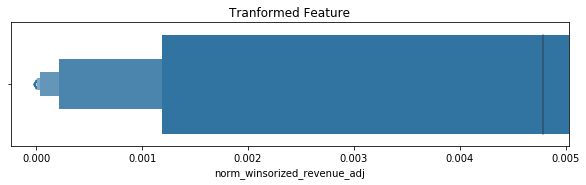

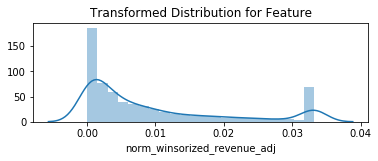

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.





 Outlier Visualization for norm_winsorized_vc_pop feature. 



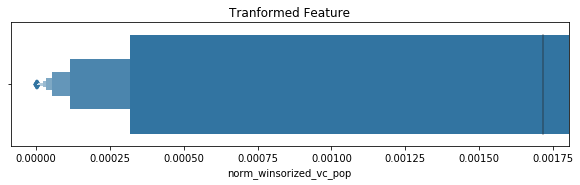

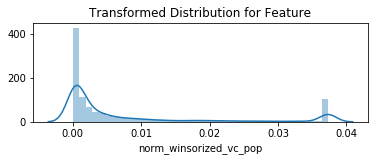

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.





 Outlier Visualization for norm_sqrt_budget_adj feature. 



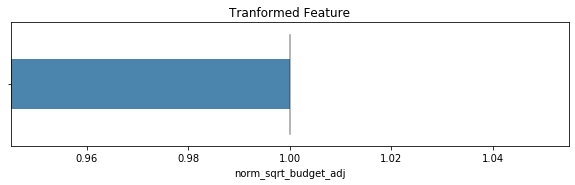

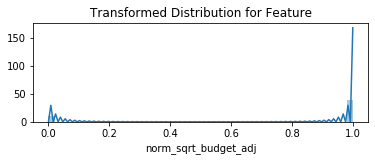

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.





 Outlier Visualization for norm_winsorized_runtime feature. 



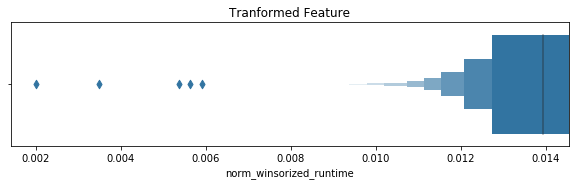

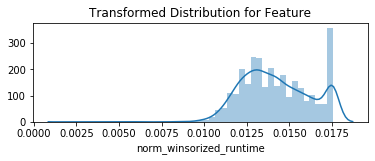

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.





 Outlier Visualization for norm_winsorized_vote_average feature. 



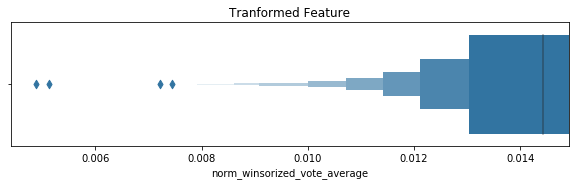

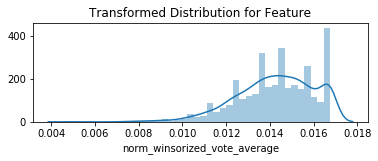

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.





 Outlier Visualization for norm_winsorized_100_actors feature. 



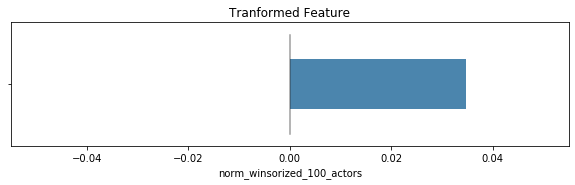

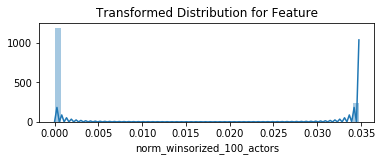




 Outlier Visualization for norm_sqrt_tagline_length feature. 



'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


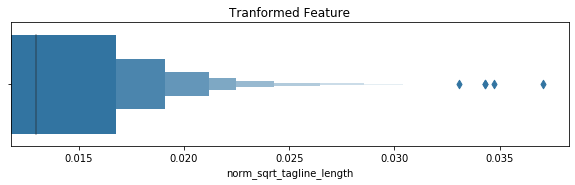

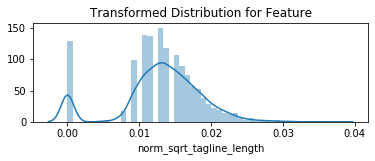

In [29]:
transformed_features = ['norm_winsorized_revenue_adj', 'norm_winsorized_vc_pop', 'norm_sqrt_budget_adj',
                    'norm_winsorized_runtime', 'norm_winsorized_vote_average', 'norm_winsorized_100_actors', 
                    'norm_sqrt_tagline_length']

for feat in transformed_features:
    print('\n Outlier Visualization for', feat, 'feature. \n')
    plt.figure(figsize = (10, 5))
    plt.subplot(2, 1, 1)
    sns.boxenplot(x=feat, data=movies)
    plt.title('Tranformed Feature')
    plt.show()
    print('\n')
    plt.subplot(2, 1, 2)
    sns.distplot(movies[feat])
    plt.title('Transformed Distribution for Feature')
    plt.show()
    print('\n')
    
   

## The Cleaned and Transformed Data

A look at the data after it's been cleaned and transformed.

In [24]:
print(movies.describe())

              id  popularity        budget        revenue  runtime  \
count   4850.000    4850.000      4850.000       4850.000 4850.000   
mean   44575.001       1.045  29569700.632   89220658.325  107.965   
std    72361.406       1.357  40513434.965  162068389.382   21.113   
min        5.000       0.001         0.000          2.000   15.000   
25%     8286.000       0.388   1700000.000    7708081.250   95.000   
50%    12154.500       0.680  15000000.000   31826540.000  104.000   
75%    43956.500       1.210  40000000.000   99918234.250  117.000   
max   417859.000      32.986 425000000.000 2781505847.000  705.000   

       vote_count  vote_average  release_year    budget_adj    revenue_adj  \
count    4850.000      4850.000      4850.000      4850.000       4850.000   
mean      436.216         6.149      2000.922  35161017.182  115440772.436   
std       806.416         0.799        11.569  43756717.053  198790975.598   
min        10.000         2.100      1960.000         0.0

# Running the Models
All cross validation models will be run with ten folds, and all models using training and testing sets will use a 70%/30% split unless otherwise specified. Each round of models will test a new set of features.

## The First Round
For our first run, I'll use all features that have correlations of greater than 0.2 with the target variable, revenue_adj. 

In [31]:
features1 = movies[['norm_winsorized_vc_pop', 'norm_sqrt_budget_adj', 'norm_winsorized_runtime',
                           'Adventure', 'norm_winsorized_100_actors', 'norm_winsorized_vote_average']]
target = movies['norm_winsorized_revenue_adj']
X1_train, X1_test, Y1_train, Y1_test = train_test_split(features1, target,
                test_size = .3, random_state = 465)
X1_train_const = sm.add_constant(X1_train)
X1_test_const = sm.add_constant(X1_test)


## OLS with Training & Testing Sets

All of the evaluation metrics are fairly low - in particular, the mean squared error is 6.467e-05. Additionally, this model gives R-squared adjusted values of 0.497 for the training set and 0.452 for the testing set

In [34]:
print("The number of observations in training set is {}".format(X1_train.shape[0]))
print("The number of observations in test set is {}".format(X1_test.shape[0]))

# We fit an OLS model using sklearn

ols = LinearRegression().fit(X1_train_const, Y1_train)

results_train = sm.OLS(Y1_train, X1_train_const).fit()
results_test = sm.OLS(Y1_test, X1_test_const).fit()
# We print the summary results
print(results_train.summary())
print('\n')
print(results_test.summary())
print('\n')

# We are making predictions here
Y1_preds_train = ols.predict(X1_train_const)
Y1_preds_test = ols.predict(X1_test_const)


print("R-squared of the model on the training set is: {}".format(ols.score(X1_train_const, Y1_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ols.score(X1_test_const, Y1_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y1_test, Y1_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y1_test, Y1_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y1_test - Y1_preds_test) / Y1_test)) * 100))

The number of observations in training set is 3395
The number of observations in test set is 1455
                                 OLS Regression Results                                
Dep. Variable:     norm_winsorized_revenue_adj   R-squared:                       0.498
Model:                                     OLS   Adj. R-squared:                  0.497
Method:                          Least Squares   F-statistic:                     559.6
Date:                         Thu, 26 Dec 2019   Prob (F-statistic):               0.00
Time:                                 14:55:02   Log-Likelihood:                 11740.
No. Observations:                         3395   AIC:                        -2.347e+04
Df Residuals:                             3388   BIC:                        -2.342e+04
Df Model:                                    6                                         
Covariance Type:                     nonrobust                                         
                      

## OLS with Cross Validation
The evaluation metrics are similar to the OLS with training & testing sets with an R-squared of 0.469 and MSE of 6.193e-05.

In [35]:
cross_val_scores = cross_val_score(LinearRegression(), features1, target, cv=10)
print('R-Squared Scores with Cross Validation: ', cross_val_scores)
print('\n OLS R-Squared Score: ', cross_val_scores.mean())

nmse_cross_val_scores = cross_val_score(LinearRegression(), features1, target, cv=10, scoring='neg_mean_squared_error')
print('OLS Negative MSE Score: ', nmse_cross_val_scores.mean())
print('Negative MSE Scores with Cross Validation: ', nmse_cross_val_scores)

R-Squared Scores with Cross Validation:  [0.3877995  0.56283839 0.6021052  0.57969109 0.51322833 0.56328224
 0.55430321 0.34482269 0.35169405 0.22914767]

 OLS R-Squared Score:  0.4688912371723265
OLS Negative MSE Score:  -6.192562605675475e-05
Negative MSE Scores with Cross Validation:  [-8.19104832e-05 -5.04433749e-05 -4.41134856e-05 -5.09877727e-05
 -5.88560549e-05 -3.75709393e-05 -4.77312691e-05 -7.60314123e-05
 -7.07412903e-05 -1.00870178e-04]


## Lasso Regression Model

The Lasso model with training sets fairs more poorly than the OLS model with an MSE of 0.0084 and an exceptionally terrible R-squared of 0.061.

In [36]:
print("The number of observations in training set is {}".format(X1_train.shape[0]))
print("The number of observations in test set is {}".format(X1_test.shape[0]))
print('\n')

lassoregr = Lasso(alpha=0.001)
 
lassoregr.fit(X1_train, Y1_train)

# We are making predictions here
Y1_preds_train = lassoregr.predict(X1_train)
Y1_preds_test = lassoregr.predict(X1_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X1_train, Y1_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X1_test, Y1_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y1_test, Y1_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y1_test, Y1_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y1_test, Y1_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y1_test - Y1_preds_test) / Y1_test)) * 100))


The number of observations in training set is 3395
The number of observations in test set is 1455


R-squared of the model on the training set is: 0.06073842307421595
-----Test set statistics-----
R-squared of the model on the test set is: 0.053783210895977485
Mean absolute error of the prediction is: 0.008473486796036154
Mean squared error of the prediction is: 0.00011109696739235598
Root mean squared error of the prediction is: 0.010540254617055319
Mean absolute percentage error of the prediction is: inf


## Lasso Regression Model with Cross Validation

The Lasso performs much better with cross validation resulting in 6.044e-05 for the MSE for the model and an R-squared of 0.48.

Using parameters obtained from GridSearchCV had very little impact the performance of the model.

In [37]:
print('Lasso Regression with Cross Validation:')
lassoregrCV = LassoCV(n_alphas=5)
lassoregrCV.fit(features1, target)

# We are making predictions here
Y1_preds = lassoregrCV.predict(features1)


print('Lasso Cross Validation Outcomes:')
print("-----Test set statistics-----")
print("R-squared of the model is: {}".format(lassoregrCV.score(features1, target)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(target, Y1_preds)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(target, Y1_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(target, Y1_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((target - Y1_preds) / target)) * 100))


Lasso Regression with Cross Validation:
Lasso Cross Validation Outcomes:
-----Test set statistics-----
R-squared of the model is: 0.4797391202479899
Mean absolute error of the prediction is: 0.005699353912294015
Mean squared error of the prediction is: 6.0436760730718465e-05
Root mean squared error of the prediction is: 0.00777410835599289
Mean absolute percentage error of the prediction is: inf


Using GridSearchCV to find the best parameters for the Lasso Model.

In [38]:
lasso_gsc = GridSearchCV(
        estimator=LassoCV(),
        param_grid={
            'eps': [0.001, 0.001, 0.1, 1]},
#             'n_alphas': [0, 1, 10]},
        cv=10, scoring='r2', verbose=1, n_jobs=-1)

grid_result = lasso_gsc.fit(features1, target)
best_params = grid_result.best_params_
# svr_gsc.best_estimator_
best_lasso = LassoCV(eps=best_params['eps'], verbose=False)
# n_alphas=best_params['n_alphas'],
print('Parameters for the best Lasso model: ', best_lasso)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Parameters for the best Lasso model:  LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.7s finished


In [39]:
print('Lasso Regression with Cross Validation:')
lassoregrCV = LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

lassoregrCV.fit(features1, target)

# We are making predictions here
Y1_preds = lassoregrCV.predict(features1)


print('Lasso Cross Validation Outcomes:')
print("-----Test set statistics-----")
print("R-squared of the model is: {}".format(lassoregrCV.score(features1, target)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(target, Y1_preds)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(target, Y1_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(target, Y1_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((target - Y1_preds) / target)) * 100))

Lasso Regression with Cross Validation:
Lasso Cross Validation Outcomes:
-----Test set statistics-----
R-squared of the model is: 0.4797391202479899
Mean absolute error of the prediction is: 0.005699353912294015
Mean squared error of the prediction is: 6.0436760730718465e-05
Root mean squared error of the prediction is: 0.00777410835599289
Mean absolute percentage error of the prediction is: inf


## Ridge Regression with Training & Testing Sets
The Ridge model performs similarly to the OLS model with an MSE of 6.467e-05 and an R-squared of 0.45 on the test set, so I will continue to test with it as we change our features.

In [40]:
ridgeregr = Ridge(alpha=0) 
ridgeregr.fit(X1_train, Y1_train)

# We are making predictions here
Y1_preds_train = ridgeregr.predict(X1_train)
Y1_preds_test = ridgeregr.predict(X1_test)

print('Ridge Testing & Training Sets Outcomes:')
print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X1_train, Y1_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X1_test, Y1_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y1_test, Y1_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y1_test, Y1_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y1_test, Y1_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y1_test - Y1_preds_test) / Y1_test)) * 100))

Ridge Testing & Training Sets Outcomes:
R-squared of the model on the training set is: 0.4977636871127311
-----Test set statistics-----
R-squared of the model on the test set is: 0.44918794220157254
Mean absolute error of the prediction is: 0.0057415252068525
Mean squared error of the prediction is: 6.467180664009657e-05
Root mean squared error of the prediction is: 0.008041878302989705
Mean absolute percentage error of the prediction is: inf


## Ridge Regression with Cross Validation
There is not much of a difference between the Ridge with training sets and the Ridge with cross validation, confirming it's a decent model.

In [41]:
ridgeCV = RidgeCV(alphas=(0.001, 0.01, .1, 1, 10), cv=10)
ridgeCV.fit(features1, target)

# We are making predictions here
Y1_preds = ridgeCV.predict(features1)

print('Ridge Cross Validation Outcomes:')
print("-----Test set statistics-----")
print("R-squared of the model is: {}".format(ridgeCV.score(features1, target)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(target, Y1_preds)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(target, Y1_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(target, Y1_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((target - Y1_preds) / target)) * 100))

Ridge Cross Validation Outcomes:
-----Test set statistics-----
R-squared of the model is: 0.4834500650873522
Mean absolute error of the prediction is: 0.005653176055046005
Mean squared error of the prediction is: 6.000567414691009e-05
Root mean squared error of the prediction is: 0.007746332948364025
Mean absolute percentage error of the prediction is: inf


## ElasticNet Regression Model with Training & Testing Sets

The ElasticNet performs similarly to our other models with an MSE very close to the Ridge model.

In [42]:
elasticregr = ElasticNet(l1_ratio=1000, alpha=0) 
elasticregr.fit(X1_train, Y1_train)

# We are making predictions here
Y1_preds_train = elasticregr.predict(X1_train)
Y1_preds_test = elasticregr.predict(X1_test)

print('ElasticNet Training & Testing Sets Outcomes:')
print("R-squared of the model on the training set is: {}".format(elasticregr.score(X1_train, Y1_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X1_test, Y1_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y1_test, Y1_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y1_test, Y1_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y1_test, Y1_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y1_test - Y1_preds_test) / Y1_test)) * 100))

ElasticNet Training & Testing Sets Outcomes:
R-squared of the model on the training set is: 0.4977636871127311
-----Test set statistics-----
R-squared of the model on the test set is: 0.44918794220157277
Mean absolute error of the prediction is: 0.005741525206852501
Mean squared error of the prediction is: 6.467180664009656e-05
Root mean squared error of the prediction is: 0.008041878302989703
Mean absolute percentage error of the prediction is: inf


## ElasticNet Regression Model with Cross Validation

This model performs terribly under cross validation and a larger MSE than the previous models, so I may drop it from the analysis.

ElasticNet performs much better with the best parameters with metrics similar to the other linear regression models.

In [44]:
elasticregrCV = ElasticNet()
elasticregrCV.fit(features1, target)

# We are making predictions here
Y1_preds = elasticregrCV.predict(features1)

print('ElasticNet Cross Validation Outcomes:')
print("R-squared of the model on the training set is: {}".format(elasticregrCV.score(features1, target)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregrCV.score(features1, target)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(target, Y1_preds)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(target, Y1_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(target, Y1_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((target - Y1_preds) / target)) * 100))


ElasticNet Cross Validation Outcomes:
R-squared of the model on the training set is: 0.0
-----Test set statistics-----
R-squared of the model on the test set is: 0.0
Mean absolute error of the prediction is: 0.008726079957242823
Mean squared error of the prediction is: 0.00011616626020300918
Root mean squared error of the prediction is: 0.010778045286739575
Mean absolute percentage error of the prediction is: inf


Using GridSearchCV to find the best parameters for the ElasticNet Model.

In [45]:
en_gsc = GridSearchCV(
        estimator=ElasticNetCV(),
        param_grid={'l1_ratio': [0.1, 0.3, 0.7, 1]}, verbose=1)
#                     ,
grid_result = en_gsc.fit(features1, target)
best_params = grid_result.best_params_
best_en = ElasticNetCV(l1_ratio=best_params['l1_ratio'])

print('Parameters for the best ElasticNet Model: ', best_en)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Parameters for the best ElasticNet Model:  ElasticNetCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
             l1_ratio=0.3, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0)


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.9s finished


In [46]:
elasticregrCV = ElasticNetCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
             l1_ratio=0.3, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0) 

elasticregrCV.fit(features1, target)

# We are making predictions here
Y1_preds = elasticregrCV.predict(features1)

print('ElasticNet Cross Validation Outcomes:')
print("R-squared of the model on the training set is: {}".format(elasticregrCV.score(features1, target)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregrCV.score(features1, target)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(target, Y1_preds)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(target, Y1_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(target, Y1_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((target - Y1_preds) / target)) * 100))


ElasticNet Cross Validation Outcomes:
R-squared of the model on the training set is: 0.47785024344780463
-----Test set statistics-----
R-squared of the model on the test set is: 0.47785024344780463
Mean absolute error of the prediction is: 0.005734932918236704
Mean squared error of the prediction is: 6.0656184484580224e-05
Root mean squared error of the prediction is: 0.007788208040658661
Mean absolute percentage error of the prediction is: inf


## Random Forests Ensemble with Training & Testing Sets

With the lowest R-squared values so far and an MSE of 0.679e-05, this model may not be as good a fit for the data as the linear regression models.

In [47]:
rfr = ensemble.RandomForestRegressor(n_estimators=200)
rfr.fit(X1_train, Y1_train)

Y1_preds_train = rfr.predict(X1_train)
Y1_preds_test = rfr.predict(X1_test)


print("R-squared of the model on the training set is: {}".format(rfr.score(X1_train, Y1_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(rfr.score(X1_test, Y1_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y1_test, Y1_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y1_test, Y1_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y1_test, Y1_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y1_test - Y1_preds_test) / Y1_test)) * 100))

R-squared of the model on the training set is: 0.9176684320178632
-----Test set statistics-----
R-squared of the model on the test set is: 0.4396580523089576
Mean absolute error of the prediction is: 0.005707679773782344
Mean squared error of the prediction is: 6.579072767261717e-05
Root mean squared error of the prediction is: 0.008111148357206714
Mean absolute percentage error of the prediction is: inf


## Random Forests Ensemble with Cross Validation

With R-squared scores ranging from 0.267 to 0.624 and an average of 0.514 and an MSE at 5.692e-05, we can see that while this model accounts for just over 50% of the variance and is the best performer so far.


In [49]:
rfr = ensemble.RandomForestRegressor(n_estimators=200)

cross_val_scores = cross_val_score(rfr, features1, target, cv=10)
print('R-Squared Scores with Cross Validation: ', cross_val_scores)
print('\n Random Forests R-Squared Score: ', cross_val_scores.mean())

R-Squared Scores with Cross Validation:  [0.31419626 0.49322954 0.57062038 0.52421019 0.5121389  0.59455949
 0.56419148 0.40481445 0.36825029 0.22350048]

 Random Forests R-Squared Score:  0.4569711440527727


In [47]:
rf_gsc = GridSearchCV(
        estimator=ensemble.RandomForestRegressor(),
        param_grid={
            'max_depth': [80, 90, 100],
            'max_features': [2, 3],
            'min_samples_leaf': [2, 3, 4],
            'min_samples_split': [8, 10, 12],
            'n_estimators': [50, 100, 500, 1000]
        },
        cv=10, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

rf_gsc.fit(features1, target)
best_params = rf_gsc.best_params_
# svr_gsc.best_estimator_
best_rf = ensemble.RandomForestRegressor(max_depth=best_params['max_depth'], max_features=best_params["max_features"],
                                         min_samples_leaf=best_params["min_samples_leaf"], min_samples_split=best_params["min_samples_split"],
                                         n_estimators=best_params['n_estimators'],verbose=False)

print('Parameters for the best Support Vector Model: ', best_rf)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 25.5min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 31.6min finished
//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Parameters for the best Support Vector Model:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
                      max_features=2, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=12,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=False, warm_start=False)


In [50]:
# Re-testing model with optimal parameters
rfr = ensemble.RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
                      max_features=2, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=12,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=False, warm_start=False)
rfr.fit(features1, target)
Y1_preds_train = rfr.predict(X1_train)
Y1_preds_test = rfr.predict(X1_test)


print("R-squared of the model on the training set is: {}".format(rfr.score(X1_train, Y1_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(rfr.score(X1_test, Y1_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y1_test, Y1_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y1_test, Y1_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y1_test, Y1_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y1_test - Y1_preds_test) / Y1_test)) * 100))

R-squared of the model on the training set is: 0.6862978216430802
-----Test set statistics-----
R-squared of the model on the test set is: 0.6630061948947067
Mean absolute error of the prediction is: 0.0044105799734088435
Mean squared error of the prediction is: 3.956703179264015e-05
Root mean squared error of the prediction is: 0.006290233047561922
Mean absolute percentage error of the prediction is: inf


In [52]:
rfr = ensemble.RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
                      max_features=2, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=12,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=False, warm_start=False)

cross_val_scores = cross_val_score(rfr, features1, target, cv=10, verbose=1)
mse_cross_val_scores = cross_val_score(rfr, features1, target, cv=10, verbose=1, scoring='neg_mean_squared_error')
print('R-Squared Scores with Cross Validation: ', cross_val_scores)
print('Mean R-Squared: ', cross_val_scores.mean())

print('\n')
print('Mean MSE: ', mse_cross_val_scores.mean())
print('MSE Scores with Cross Validation: ', mse_cross_val_scores)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


R-Squared Scores with Cross Validation:  [0.4175643  0.54693258 0.62448899 0.59544446 0.54578016 0.64481922
 0.61598986 0.46005168 0.42587247 0.26673175]
Mean R-Squared:  0.514367546500375


Mean MSE:  -5.69244036130592e-05
MSE Scores with Cross Validation:  [-7.80464620e-05 -5.24913262e-05 -4.17158868e-05 -4.90271482e-05
 -5.49257025e-05 -3.05223902e-05 -4.11288311e-05 -6.24824160e-05
 -6.28648956e-05 -9.60389775e-05]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.0s finished


## Support Vector Machines with Training & Testing Sets

This is by far the worst model with an R-squared of -0.421 and an MSE of 1.667e-04.

In [53]:
svr = SVR()
svr.fit(X1_train, Y1_train)

Y1_preds_train = svr.predict(X1_train)
Y1_preds_test = svr.predict(X1_test)


print("R-squared of the model on the training set is: {}".format(svr.score(X1_train, Y1_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(svr.score(X1_test, Y1_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y1_test, Y1_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y1_test, Y1_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y1_test, Y1_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y1_test - Y1_preds_test) / Y1_test)) * 100))

R-squared of the model on the training set is: -0.4405130217226057
-----Test set statistics-----
R-squared of the model on the test set is: -0.4206006529780506
Mean absolute error of the prediction is: 0.011980205363732864
Mean squared error of the prediction is: 0.0001667952061714175
Root mean squared error of the prediction is: 0.012914921841475368
Mean absolute percentage error of the prediction is: inf


## Support Vector Machines with Cross Validation
With the largest MSE and a negative R-squared, this is clearly the worst model.

Utilizing GridSearchCV for the best parameters has a great affect on the performance of the model, increasing the R-squared to 0.454 and decreasing the MSE to 6.556e-05. 

In [54]:
svr = SVR()
svr.fit(features1, target)
print('\n SVR R-Squared Score: ', svr.score(features1, target))
print('\n SVR R-Squared Scores with Cross Validation: ', cross_val_score(svr, features1, target, cv=10, scoring='r2'))

nmse_cross_val_score = cross_val_score(svr, features1, target, cv=10, scoring='neg_mean_squared_error')
print('\n SVR Mean Squared Error Scores with Cross Validation: ', nmse_cross_val_score)
print('\n SVR Mean Negative MSE Score with Cross Validation: ', nmse_cross_val_score.mean())


 SVR R-Squared Score:  -0.4344439760748602

 SVR R-Squared Scores with Cross Validation:  [-0.41214319 -0.52608473 -0.42173179 -0.46721698 -0.41525032 -0.9302101
 -0.5357191  -0.29229529 -0.44384123 -0.19627417]

 SVR Mean Squared Error Scores with Cross Validation:  [-0.00018894 -0.00017609 -0.00015762 -0.00017799 -0.00017112 -0.00016606
 -0.00016447 -0.00014997 -0.00015755 -0.00015654]

 SVR Mean Negative MSE Score with Cross Validation:  -0.00016663399217135122


Using GridSearchCV to find the best parameters for the SVM Model.

In [56]:
svr_gsc = GridSearchCV(
        estimator=SVR(kernel='rbf'),
        param_grid={
            'C': [0.1, 1, 100],
            'epsilon': [0.0001, .001, 0.1],
            'gamma': [0.001, 0.01, 0.1, 1]
        },
        cv=10, verbose=1, n_jobs=-1)


svr_gsc.fit(features1, target)
best_params = svr_gsc.best_params_
# svr_gsc.best_estimator_
best_svr = SVR(kernel='rbf', C=best_params["C"], epsilon=best_params["epsilon"], gamma=best_params["gamma"],
                   coef0=0.1, shrinking=True,
                   tol=0.001, cache_size=200, verbose=False, max_iter=-1)

print('Parameters for the best Support Vector Model: ', best_svr)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 340 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 353 out of 360 | elapsed:  1.8min remaining:    2.2s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  1.8min finished


Parameters for the best Support Vector Model:  SVR(C=100, cache_size=200, coef0=0.1, degree=3, epsilon=0.001, gamma=1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [57]:
svr = SVR(C=100, cache_size=200, coef0=0.1, degree=3, epsilon=0.0001, gamma=0.001,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

svr.fit(features1, target)
print('\n SVR Score: ', svr.score(features1, target))
print('\n SVR R-Squared Scores with Cross Validation: ', cross_val_score(svr, features1, target, cv=10, scoring='r2'))
nmse_cross_val_score = cross_val_score(svr, features1, target, cv=10, scoring='neg_mean_squared_error')

print('\n SVR Mean Negative MSE Score with Cross Validation: ', nmse_cross_val_score.mean())
print('\n SVR Negative MSE Scores with Cross Validation: ', nmse_cross_val_score)


 SVR Score:  0.45389465976648924

 SVR R-Squared Scores with Cross Validation:  [0.39109231 0.57741988 0.62037336 0.58513965 0.51331446 0.56739399
 0.53818445 0.2390017  0.25071733 0.1030957 ]

 SVR Mean Negative MSE Score with Cross Validation:  -6.556020062692579e-05

 SVR Negative MSE Scores with Cross Validation:  [-8.14699153e-05 -4.87608411e-05 -4.20881456e-05 -5.03268066e-05
 -5.88456414e-05 -3.72172043e-05 -4.94574847e-05 -8.83116294e-05
 -8.17595808e-05 -1.17364757e-04]


## Gradient Boosting with Training & Testing Sets

The mean squared error is quite low at 5.990e-05. Using the parameters obtained with GridSearchCV slightly increases the performance of the model.

In [58]:
gbr = ensemble.GradientBoostingRegressor(n_estimators=500, max_depth=3, loss='ls')

gbr.fit(X1_train, Y1_train)

Y1_preds_train = gbr.predict(X1_train)
Y1_preds_test = gbr.predict(X1_test)


print("R-squared of the model on the training set is: {}".format(gbr.score(X1_train, Y1_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(gbr.score(X1_test, Y1_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y1_test, Y1_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y1_test, Y1_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y1_test, Y1_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y1_test - Y1_preds_test) / Y1_test)) * 100))



R-squared of the model on the training set is: 0.7332719027872427
-----Test set statistics-----
R-squared of the model on the test set is: 0.48984966160297655
Mean absolute error of the prediction is: 0.005433926294293787
Mean squared error of the prediction is: 5.989764308003923e-05
Root mean squared error of the prediction is: 0.0077393567613878115
Mean absolute percentage error of the prediction is: inf


In [59]:
# Using GridSearchCV to find the best parameters for the Gradient Boosting
gbr_gsc = GridSearchCV(
        estimator= ensemble.GradientBoostingRegressor(loss='ls'),
        param_grid={
            'learning_rate': [0.001, 0.01, 0.1],
            'n_estimators': [500, 700, 900]},
        cv=10, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

grid_result = gbr_gsc.fit(features1, target)
best_params = grid_result.best_params_
best_gbr = ensemble.GradientBoostingRegressor(learning_rate=best_params['learning_rate'], 
                        n_estimators=best_params['n_estimators'], tol=0.001)

print(best_gbr)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.0min finished


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=900,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [60]:
gbr = ensemble.GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=900,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
gbr.fit(X1_train, Y1_train)

Y1_preds_train = gbr.predict(X1_train)
Y1_preds_test = gbr.predict(X1_test)


print("R-squared of the model on the training set is: {}".format(gbr.score(X1_train, Y1_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(gbr.score(X1_test, Y1_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y1_test, Y1_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y1_test, Y1_preds_test)))
print("Root mean squared error of the prediction is: {}".format(sqrt(mean_squared_error(Y1_test, Y1_preds_test))))
print("Root mean squared error of the prediction is: {}".format(rmse(Y1_test, Y1_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y1_test - Y1_preds_test) / Y1_test)) * 100))


R-squared of the model on the training set is: 0.6061408986059773
-----Test set statistics-----
R-squared of the model on the test set is: 0.5091091368102534
Mean absolute error of the prediction is: 0.005319509787314317
Mean squared error of the prediction is: 5.763635442638641e-05
Root mean squared error of the prediction is: 0.007591861064744692
Root mean squared error of the prediction is: 0.007591861064744692
Mean absolute percentage error of the prediction is: inf


## Gradient Boosting with Cross Validation

This model has the highest performace with an R-squared of 0.521 and lowest MSE with 5.618e-05, this is the best model.

In [61]:
gbr = ensemble.GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=700,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


cross_val_scores = cross_val_score(gbr, features1, target, cv=10)
nmse_cross_val_score = cross_val_score(gbr, features1, target, cv=10, scoring='neg_mean_squared_error')
print('R-Squared Scores with Cross Validation: ', cross_val_scores)
print('\n Gradient Boosting R-Squared Score: ', cross_val_scores.mean())
print('\n Negative MSE Scores with Cross Validation: ', nmse_cross_val_score)
print('\n Mean Negative MSE Scores with Cross Validation: ', nmse_cross_val_score.mean())

R-Squared Scores with Cross Validation:  [0.39679051 0.57366581 0.63045141 0.62238286 0.55261748 0.64696026
 0.61719639 0.47347045 0.44580743 0.25069359]

 Gradient Boosting R-Squared Score:  0.5210036191523522

 Negative MSE Scores with Cross Validation:  [-8.07105873e-05 -4.91940166e-05 -4.09708200e-05 -4.58088248e-05
 -5.40901379e-05 -3.03720976e-05 -4.09958120e-05 -6.10980028e-05
 -6.04764168e-05 -9.80507791e-05]

 Mean Negative MSE Scores with Cross Validation:  -5.617674948580402e-05


## XGBoost with Training & Testing Sets

The first time this model is run, all evaluation metrics are absolutely terrible. Using the metrics obtained by GridSearchCV increse the performance of the model, but it is still one of the lowest performers.

In [62]:
xg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xg.fit(X1_train,Y1_train)
Y1_preds_train = xg.predict(X1_train)
Y1_preds_test = xg.predict(X1_test)

print("MSE of train set: %f" % (mean_squared_error(Y1_train, Y1_preds_train)))
print("MSE of test set: %f" % (mean_squared_error(Y1_test, Y1_preds_test)))


print("R-squared of the model on the training set is: {}".format(xg.score(X1_train, Y1_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(xg.score(X1_test, Y1_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y1_test, Y1_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y1_test, Y1_preds_test)))
print("Root mean squared error of the prediction is: {}".format(sqrt(mean_squared_error(Y1_test, Y1_preds_test))))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y1_test - Y1_preds_test) / Y1_test)) * 100))



MSE of train set: 0.029380
MSE of test set: 0.029334
R-squared of the model on the training set is: -253.08585665074074
-----Test set statistics-----
R-squared of the model on the test set is: -248.83517498557697
Mean absolute error of the prediction is: 0.1709666068373218
Mean squared error of the prediction is: 0.029333584658879735
Root mean squared error of the prediction is: 0.1712705014264854
Mean absolute percentage error of the prediction is: inf


Using GridSearchCV to find the best parameters for the Gradient Boosting model.

In [181]:
gbm_param_grid = {
    'learning_rate': [0.3, 0.5],
     'colsample_bytree': np.linspace(0.5, 0.9),
     'n_estimators': [100, 200],
     'max_depth': [10, 20],
    'objective' : ['reg:squarederror']
}

gbm = xgb.XGBRegressor()

grid_mse = GridSearchCV(estimator = gbm, param_grid = gbm_param_grid, scoring = 'neg_mean_squared_error', cv = 10, verbose = 1)

grid_mse.fit(X1_train, Y1_train)

print("Best parameters found: ",grid_mse.best_params_)
print("Lowest MSE found: ", np.abs(grid_mse.best_score_))


Fitting 10 folds for each of 400 candidates, totalling 4000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed: 103.1min finished


Best parameters found:  {'colsample_bytree': 0.8346938775510204, 'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 100, 'objective': 'reg:squarederror'}
Lowest MSE found:  2.155825975478203e+16


In [63]:
xg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.8346938775510204, learning_rate = 0.3,
                max_depth = 10, n_estimators = 100)

xg.fit(X1_train, Y1_train)
Y1_preds_train = xg.predict(X1_train)
Y1_preds_test = xg.predict(X1_test)

print("MSE of train set: %f" % (mean_squared_error(Y1_train, Y1_preds_train)))
print("MSE of test set: %f" % (mean_squared_error(Y1_test, Y1_preds_test)))


print("R-squared of the model on the training set is: {}".format(xg.score(X1_train, Y1_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(xg.score(X1_test, Y1_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y1_test, Y1_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y1_test, Y1_preds_test)))
print("Root mean squared error of the prediction is: {}".format(sqrt(mean_squared_error(Y1_test, Y1_preds_test))))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y1_test - Y1_preds_test) / Y1_test)) * 100))

MSE of train set: 0.000008
MSE of test set: 0.000070
R-squared of the model on the training set is: 0.9284695538014623
-----Test set statistics-----
R-squared of the model on the test set is: 0.4054705224351252
Mean absolute error of the prediction is: 0.005834246729772908
Mean squared error of the prediction is: 6.980474532201317e-05
Root mean squared error of the prediction is: 0.00835492341808189
Mean absolute percentage error of the prediction is: inf


## XGBoost with Cross Validation

The cross validation provides mixed results - the XGBoost score is quite high at 0.808, but the scores for each fold range from 0.216 to 0.703. This indicates to me that the model is overfitting. The array for negative MSEs is quite small, ranging from .0000322 to .000103 which is similar to the rest of the models.

In [65]:
xg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.8346938775510204, learning_rate = 0.3,
                max_depth = 10, alpha = 10, n_estimators = 100)
xg.fit(features1,target)
cross_val_scores = cross_val_score(xg, features1, target, cv=10)
nmse_cross_val_score = cross_val_score(xg, features1, target, cv=10, scoring='neg_mean_squared_error')
print('XGBoost Score: ', xg.score(features1, target))
print('XGBoost mean of R-squared array: ', cross_val_scores.mean())
print('XGBoost R-squared array: ', cross_val_scores)
print('XGBoost Negative MSE Mean: ', nmse_cross_val_score.mean())
print('XGBoost Negative MSE array: ', cross_val_score(xg, features1, target, cv=10, scoring='neg_mean_squared_error'))

XGBoost Score:  0.9226760452223264
XGBoost mean of R-squared array:  0.4390141967666098
XGBoost R-squared array:  [0.36123283 0.44407284 0.56089446 0.50893297 0.50540267 0.52026778
 0.53644879 0.41349474 0.32642209 0.2129728 ]
XGBoost Negative MSE Mean:  -6.531313964061383e-05
XGBoost Negative MSE array:  [-8.54650191e-05 -6.41475407e-05 -4.86824051e-05 -5.95714579e-05
 -5.98022638e-05 -4.12714838e-05 -4.96433625e-05 -6.80622222e-05
 -7.34988943e-05 -1.02986747e-04]


## Round 1 Summary
All metrics obtained from cross validation.

|Model | R-Squared Value |Mean Squared Error
------|------|------|
|OLS |0.4689 | 6.193e-05|
|Lasso Regression |0.479 | 6.044e-05|
|Ridge Regression |0.483 | 6.001e-05|
|ElasticNet  |0.477 | 6.066e-05|
|Random Forests  |0.514 | 5.692e-05|
|Support Vector Machines |0.454 | 6.556e-05|
|Gradient Boosting |0.521| 5.618e-05|
|XGBoost |0.439|6.531e-05|


## Second Round
In this round, I will use all the features available to me in the data. Moving forward, I will use GridSearchCV to obtain the best parameters of each model.

In [66]:
features2 = movies[['norm_sqrt_budget_adj', 'norm_winsorized_vc_pop', 'norm_winsorized_runtime', 'Adventure', 
                           'norm_winsorized_100_actors', 'norm_winsorized_vote_average', 'Action', 'Family', 
                           'Animation', 'Fantasy', 'homepage_dummy', 'Science Fiction','War', 'norm_sqrt_tagline_length', 
                           'Western', 'Thriller', 'History', 'TV Movie', 'Mystery', 'Comedy','Crime', 'Music', 
                           'Romance', 'Foreign', 'Horror', 'Documentary', 'release_year', 'Drama']]

X2_train, X2_test, Y2_train, Y2_test = train_test_split(features2, target2, test_size = .3, random_state = 465)
X2_train_const = sm.add_constant(X2_train)
X2_test_const = sm.add_constant(X2_test)


## OLS with Training and Test Sets
I've decreased the MSE to 5.437e-05 and increased the R-squareds from 0.572 to 0.543 for the training and test sets respectively. The gap between the lowest scoring fold and the highest scoring fold has closed slightly, indicating there is less overfitting. However, the AIC and BIC for both the training and test sets are slightly larger than the first OLS model we ran.

In [67]:
print("The number of observations in training set is {}".format(X2_train.shape[0]))
print("The number of observations in test set is {}".format(X2_test.shape[0]))

# We fit an OLS model using sklearn

ols = LinearRegression().fit(X2_train_const, Y2_train)

results_train = sm.OLS(Y2_train, X2_train_const).fit()
results_test = sm.OLS(Y2_test, X2_test_const).fit()
# We print the summary results
print(results_train.summary())
print('\n')
print(results_test.summary())
print('\n')

# We are making predictions here
Y2_preds_train = ols.predict(X2_train_const)
Y2_preds_test = ols.predict(X2_test_const)


print("R-squared of the model on the training set is: {}".format(ols.score(X2_train_const, Y2_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ols.score(X2_test_const, Y2_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y2_test, Y2_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y2_test, Y2_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y2_test, Y2_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y2_test - Y2_preds_test) / Y2_test)) * 100))

The number of observations in training set is 3395
The number of observations in test set is 1455
                                 OLS Regression Results                                
Dep. Variable:     norm_winsorized_revenue_adj   R-squared:                       0.576
Model:                                     OLS   Adj. R-squared:                  0.572
Method:                          Least Squares   F-statistic:                     163.2
Date:                         Thu, 26 Dec 2019   Prob (F-statistic):               0.00
Time:                                 15:36:56   Log-Likelihood:                 12026.
No. Observations:                         3395   AIC:                        -2.399e+04
Df Residuals:                             3366   BIC:                        -2.382e+04
Df Model:                                   28                                         
Covariance Type:                     nonrobust                                         
                      

## OLS with Cross Validation

In [69]:
cross_val_scores = cross_val_score(LinearRegression(), features2, target, cv=10)
nmse_cross_val_scores = cross_val_score(LinearRegression(), features2, target, cv=10, scoring='neg_mean_squared_error')
print('R-Squared Scores with Cross Validation: ', cross_val_scores)
print('\n OLS R-Squared Score: ', cross_val_scores.mean())
print('\n')
print('Negative MSE Score: ', nmse_cross_val_scores.mean())
print('Negative MSE Scores with Cross Validation: ', nmse_cross_val_scores)

R-Squared Scores with Cross Validation:  [0.58641448 0.60944943 0.66291373 0.62926927 0.60226075 0.59783521
 0.6264454  0.42122668 0.41474398 0.36573842]

 OLS R-Squared Score:  0.5516297349598511


Negative MSE Score:  -5.194643321477931e-05
Negative MSE Scores with Cross Validation:  [-5.53364292e-05 -4.50650027e-05 -3.73718138e-05 -4.49734327e-05
 -4.80910555e-05 -3.45983379e-05 -4.00053025e-05 -6.71649526e-05
 -6.38614623e-05 -8.29965429e-05]


## Lasso Regression with Training & Testing Sets

The Lasso performs in line with the other linear regression models with an MSE at 5.59e-05 with cross validation.

In [71]:
print("The number of observations in training set is {}".format(X2_train.shape[0]))
print("The number of observations in test set is {}".format(X2_test.shape[0]))
print('\n')

lassoregr = Lasso(alpha=0.001)
 
lassoregr.fit(X2_train, Y2_train)

# We are making predictions here
Y2_preds_train = lassoregr.predict(X2_train)
Y2_preds_test = lassoregr.predict(X2_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X2_train, Y2_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X2_test, Y2_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y2_test, Y2_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y2_test, Y2_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y2_test, Y2_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y2_test - Y2_preds_test) / Y2_test)) * 100))


The number of observations in training set is 3395
The number of observations in test set is 1455


R-squared of the model on the training set is: 0.07155708272560024
-----Test set statistics-----
R-squared of the model on the test set is: 0.07965328011091688
Mean absolute error of the prediction is: 0.00837421794924104
Mean squared error of the prediction is: 0.00010805951733957094
Root mean squared error of the prediction is: 0.010395167980344086
Mean absolute percentage error of the prediction is: inf


## Lasso with Cross Validation
 
The Lasso is still a decent model with a low MSE of 5.5942e-05.

Using GridSearchCV to find the best parameters.

In [73]:
lasso_gsc = GridSearchCV(
        estimator=LassoCV(),
        param_grid={
            'eps': [0.001, 0.001, 0.1, 1]},
#             'n_alphas': [0, 1, 10]},
        cv=10, scoring='r2', verbose=1, n_jobs=-1)

grid_result = lasso_gsc.fit(features2, target)
best_params = grid_result.best_params_
# svr_gsc.best_estimator_
best_lasso = LassoCV(eps=best_params['eps'], verbose=False)
# n_alphas=best_params['n_alphas'],
print('Parameters for the best Lasso model: ', best_lasso)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Parameters for the best Lasso model:  LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   10.0s finished


In [75]:
print('Lasso Regression with Cross Validation:')
lassoregrCV = LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

lassoregrCV.fit(features2, target)

# We are making predictions here
Y2_preds = lassoregrCV.predict(features2)


print('Lasso Cross Validation Outcomes:')
print("-----Test set statistics-----")
print("R-squared of the model is: {}".format(lassoregrCV.score(features2, target)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(target, Y2_preds)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(target, Y2_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(target, Y2_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((target - Y2_preds) / target)) * 100))

Lasso Regression with Cross Validation:
Lasso Cross Validation Outcomes:
-----Test set statistics-----
R-squared of the model is: 0.518423941274669
Mean absolute error of the prediction is: 0.005664272459910907
Mean squared error of the prediction is: 5.594288974542644e-05
Root mean squared error of the prediction is: 0.007479497960787639
Mean absolute percentage error of the prediction is: inf


## Ridge Regression with Training & Testing Sets
Both Ridge models have increased in performance with the additional features and are scoring similiarly to the OLS model.

In [76]:
ridgeregr = Ridge(alpha=0.1) 
ridgeregr.fit(X2_train, Y2_train)

# We are making predictions here
Y2_preds_train = ridgeregr.predict(X2_train)
Y2_preds_test = ridgeregr.predict(X2_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X2_train, Y2_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X2_test, Y2_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y2_test, Y2_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y2_test, Y2_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y2_test, Y2_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y2_test - Y2_preds_test) / Y2_test)) * 100))

R-squared of the model on the training set is: 0.5487717005359134
-----Test set statistics-----
R-squared of the model on the test set is: 0.5112823941257734
Mean absolute error of the prediction is: 0.005648634159529383
Mean squared error of the prediction is: 5.738118848566563e-05
Root mean squared error of the prediction is: 0.007575037193681997
Mean absolute percentage error of the prediction is: inf


## Ridge With Cross Validation
Evaluation metrics are identical to those of the previous Ridge model (training/testing sets), no matter how I change the folds and alphas.

In [77]:
ridgeCV = RidgeCV(alphas=(0.1, 10), cv=5)
ridgeCV.fit(X2_train, Y2_train)

# We are making predictions here
Y2_preds_train = ridgeCV.predict(X2_train)
Y2_preds_test = ridgeCV.predict(X2_test)

print("R-squared of the model on the training set is: {}".format(ridgeCV.score(X2_train, Y2_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeCV.score(X2_test, Y2_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y2_test, Y2_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y2_test, Y2_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y2_test, Y2_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y2_test - Y2_preds_test) / Y2_test)) * 100))

R-squared of the model on the training set is: 0.5487717005359134
-----Test set statistics-----
R-squared of the model on the test set is: 0.5112823941257734
Mean absolute error of the prediction is: 0.005648634159529383
Mean squared error of the prediction is: 5.738118848566563e-05
Root mean squared error of the prediction is: 0.007575037193681997
Mean absolute percentage error of the prediction is: inf


## ElasticNet With Training & Testing Sets

The ElasticNet performs much better using all the features when we use training and tesing sets. However, it produces poor scores in cross validation indicating there is much overfitting. I will drop it from the analysis.

In [78]:
# Using GridSearchCV to find the best parameters for the ElasticNEt
en_gsc = GridSearchCV(
        estimator=ElasticNetCV(),
        param_grid={'l1_ratio': [0.001, 0.1, 0.3]}, verbose=1)
#                     ,
grid_result = en_gsc.fit(features2, target)
best_params = grid_result.best_params_
best_en = ElasticNetCV(l1_ratio=best_params['l1_ratio'])

print('Parameters for the best ElasticNet Model: ', best_en)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Parameters for the best ElasticNet Model:  ElasticNetCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
             l1_ratio=0.3, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0)


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.7s finished


In [80]:
elasticregr = ElasticNet(l1_ratio=0.1, max_iter=1000, alpha=0)
elasticregr.fit(X2_train, Y2_train)

# We are making predictions here
Y2_preds_train = elasticregr.predict(X2_train)
Y2_preds_test = elasticregr.predict(X2_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X2_train, Y2_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X2_test, Y2_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y2_test, Y2_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y2_test, Y2_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y2_test, Y2_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y2_test - Y2_preds_test) / Y2_test)) * 100))

R-squared of the model on the training set is: 0.5757744137947027
-----Test set statistics-----
R-squared of the model on the test set is: 0.5369053674897295
Mean absolute error of the prediction is: 0.005335027580157144
Mean squared error of the prediction is: 5.4372750388719444e-05
Root mean squared error of the prediction is: 0.007373788062367906
Mean absolute percentage error of the prediction is: inf


## ElasticNet with Cross Validation

This MSE has increased to 6.137e-05 and the R-squareds have decreased, indicating this model performs more poorly with these features - perhaps there is overfitting.

In [82]:
elasticregrCV = ElasticNetCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
             l1_ratio=0.3, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0) 
elasticregrCV.fit(X2_train, Y2_train)

# We are making predictions here
Y2_preds_train = elasticregrCV.predict(X2_train)
Y2_preds_test = elasticregrCV.predict(X2_test)

print("R-squared of the model on the training set is: {}".format(elasticregrCV.score(X2_train, Y2_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregrCV.score(X2_test, Y2_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y2_test, Y2_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y2_test, Y2_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y2_test, Y2_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y2_test - Y2_preds_test) / Y2_test))))

R-squared of the model on the training set is: 0.512301331650683
-----Test set statistics-----
R-squared of the model on the test set is: 0.47732793674620744
Mean absolute error of the prediction is: 0.00594360899933085
Mean squared error of the prediction is: 6.136784068605062e-05
Root mean squared error of the prediction is: 0.007833762868893252
Mean absolute percentage error of the prediction is: inf


## Random Forests
While there is much overfitting, this model performs better than in the first round with a decrease in MSE to 4.622e-05.

In [256]:
# Using GridSearchCV to find the best parameters for the Random Forests.
rf_gsc = GridSearchCV(
        estimator=ensemble.RandomForestRegressor(),
        param_grid={
            'max_depth': [80, 90, 100],
            'max_features': [3, 4],
            'min_samples_leaf': [2, 3, 4],
            'min_samples_split': [6, 8, 10],
            'n_estimators': [500, 1000, 1250]
        },
        cv=10, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)


rf_gsc.fit(features2, target2)
best_params = rf_gsc.best_params_
# svr_gsc.best_estimator_
best_rf = ensemble.RandomForestRegressor(max_depth=best_params['max_depth'], max_features=best_params["max_features"],
                                         min_samples_leaf=best_params["min_samples_leaf"], min_samples_split=best_params["min_samples_split"],
                                         n_estimators=best_params['n_estimators'],verbose=False)

print('Parameters for the best Support Vector Model: ', best_rf)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 23.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 35.8min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 46.0min finished


Parameters for the best Support Vector Model:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
                      max_features=4, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=6,
                      min_weight_fraction_leaf=0.0, n_estimators=1250,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=False, warm_start=False)


In [83]:
rfr = ensemble.RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
                      max_features=4, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=6,
                      min_weight_fraction_leaf=0.0, n_estimators=1250,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=False, warm_start=False)
rfr.fit(X2_train, Y2_train)

Y2_preds_train = rfr.predict(X2_train)
Y2_preds_test = rfr.predict(X2_test)


print("R-squared of the model on the training set is: {}".format(rfr.score(X2_train, Y2_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(rfr.score(X2_test, Y2_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y2_test, Y2_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y2_test, Y2_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y2_test, Y2_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y2_test - Y2_preds_test) / Y2_test)) * 100))

R-squared of the model on the training set is: 0.8142101862325506
-----Test set statistics-----
R-squared of the model on the test set is: 0.6062598073685828
Mean absolute error of the prediction is: 0.0049092805567251185
Mean squared error of the prediction is: 4.622972435656453e-05
Root mean squared error of the prediction is: 0.0067992443960019945
Mean absolute percentage error of the prediction is: inf


In [84]:
rfr = ensemble.RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
                      max_features=4, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=6,
                      min_weight_fraction_leaf=0.0, n_estimators=1250,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=False, warm_start=False)

cross_val_scores = cross_val_score(rfr, features2, target, cv=10, verbose=1)
nmse_cross_val_score = cross_val_score(rfr, features2, target, cv=10, verbose=1, scoring='neg_mean_squared_error')
print('Mean R-Squared: ', cross_val_scores.mean())
print('Cross Validation Scores: ', cross_val_scores)
print('\n')
print('Mean Negative MSE: ', nmse_cross_val_score.mean())
print('Cross Validation MSE Scores: ', nmse_cross_val_score)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   46.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean R-Squared:  0.6213026180182644
Cross Validation Scores:  [0.66072785 0.62628067 0.6865603  0.68242549 0.68007722 0.66522167
 0.6744997  0.56483819 0.54694805 0.42544705]


Mean Negative MSE:  -4.386260348971032e-05
Cross Validation MSE Scores:  [-4.54388779e-05 -4.30274760e-05 -3.46539065e-05 -3.86011146e-05
 -3.83548246e-05 -2.86858094e-05 -3.50923157e-05 -5.02802416e-05
 -4.96405436e-05 -7.48509250e-05]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   55.7s finished


## SVR
Again, the Support Vector Machines model provides the worst MSE at 1.667e-04 and and R-squared of -0.44, so I will drop this model from the next round of features.

In [74]:

# Using GridSearchCV to find the best parameters for the support vectors
svr_ve_gsc = GridSearchCV(
        estimator=SVR(kernel='rbf'),
        param_grid={
            'C': [0.1, 1, 100, 200],
            'epsilon': [0.00001, 0.0001, .001, 0.1],
            'gamma': [0.0001, 0.001, 0.01]
        },
        cv=10, scoring='explained_variance', verbose=1, n_jobs=-1)

svr_ve_gsc.fit(X2_train, Y2_train)
best_params = svr_ve_gsc.best_params_
# svr_gsc.best_estimator_
best_svr = SVR(kernel='rbf', C=best_params["C"], epsilon=best_params["epsilon"], gamma=best_params["gamma"],
                   coef0=0.1, shrinking=True,
                   tol=0.001, cache_size=200, verbose=False, max_iter=-1)

print('Parameters for the best Support Vector Model: ', best_svr)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  1.8min finished


Parameters for the best Support Vector Model:  SVR(C=200, cache_size=200, coef0=0.1, degree=3, epsilon=1e-05, gamma=0.0001,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [85]:
svr = SVR(C=200, cache_size=200, coef0=0.1, degree=3, epsilon=0.1, gamma=0.0001,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

svr.fit(X2_train, Y2_train)

# We are making predictions here
Y2_preds_train = svr.predict(X2_train)
Y2_preds_test = svr.predict(X2_test)


print("R-squared of the model on the training set is: {}".format(svr.score(X2_train, Y2_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(svr.score(X2_test, Y2_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y2_test, Y2_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y2_test, Y2_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y2_test, Y2_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y2_test - Y2_preds_test) / Y2_test)) * 100))

R-squared of the model on the training set is: -0.4405130217226057
-----Test set statistics-----
R-squared of the model on the test set is: -0.4206006529780506
Mean absolute error of the prediction is: 0.011980205363732864
Mean squared error of the prediction is: 0.0001667952061714175
Root mean squared error of the prediction is: 0.012914921841475368
Mean absolute percentage error of the prediction is: inf


In [86]:
svr = SVR(C=200, cache_size=200, coef0=0.1, degree=3, epsilon=0.1, gamma=0.0001,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


cross_val_scores = cross_val_score(svr, features2, target2, cv=10, verbose=1)
nmse_cross_val_score = cross_val_score(svr, features2, target, cv=10, verbose=1, scoring='neg_mean_squared_error')
print('Mean R-Squared: ', cross_val_scores.mean())
print('Cross Validation Scores: ', cross_val_scores)
print('\n')
print('Mean Negative MSE: ', nmse_cross_val_score.mean())
print('Cross Validation MSE Scores: ', nmse_cross_val_score)

Mean R-Squared:  -0.4640766889586782
Cross Validation Scores:  [-0.41214319 -0.52608473 -0.42173179 -0.46721698 -0.41525032 -0.9302101
 -0.5357191  -0.29229529 -0.44384123 -0.19627417]


Mean Negative MSE:  -0.00016663399217135122
Cross Validation MSE Scores:  [-0.00018894 -0.00017609 -0.00015762 -0.00017799 -0.00017112 -0.00016606
 -0.00016447 -0.00014997 -0.00015755 -0.00015654]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


## Gradient Boosting
This model's performance has increased the R-squared values and decreased the MSE with the additional features both  with testing and training sets as well as cross validation.

In [114]:
# Using GridSearchCV to find the best parameters for the Gradient Boosting
gbr_gsc = GridSearchCV(
        estimator= ensemble.GradientBoostingRegressor(loss='ls'),
        param_grid={
            'learning_rate':[0.001, 0.01, 0.1],
            'n_estimators': [500, 1000, 1200],
            'max_depth': [3, 4, 5]
        },
        cv=10, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

grid_result = gbr_gsc.fit(features2, target)
best_params = grid_result.best_params_
best_gbr = ensemble.GradientBoostingRegressor(learning_rate=best_params['learning_rate'], n_estimators=best_params['n_estimators'], 
                    max_depth=best_params['max_depth'],  tol=0.001)

print(best_gbr)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 12.6min finished


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1200,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [118]:
gbr = ensemble.GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1200,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
gbr.fit(X2_train, Y2_train)

Y2_preds_train = gbr.predict(X2_train)
Y2_preds_test = gbr.predict(X2_test)


print("R-squared of the model on the training set is: {}".format(gbr.score(X2_train, Y2_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(gbr.score(X2_test, Y2_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y2_test, Y2_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y2_test, Y2_preds_test)))
print("Root mean squared error of the prediction is: {}".format(sqrt(mean_squared_error(Y2_test, Y2_preds_test))))
print("Root mean squared error of the prediction is: {}".format(rmse(Y2_test, Y2_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y2_test - Y2_preds_test) / Y2_test)) * 100))

R-squared of the model on the training set is: 0.7563337374284698
-----Test set statistics-----
R-squared of the model on the test set is: 0.6570464846903892
Mean absolute error of the prediction is: 0.004400885854764467
Mean squared error of the prediction is: 4.0266771786541445e-05
Root mean squared error of the prediction is: 0.006345610434508366
Root mean squared error of the prediction is: 0.006345610434508366
Mean absolute percentage error of the prediction is: inf


In [88]:
gbr = ensemble.GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

cross_val_scores = cross_val_score(gbr, features2, target, cv=10, verbose=1)
nmse_cross_val_score = cross_val_score(gbr, features2, target, cv=10, verbose=1, scoring='neg_mean_squared_error')
print('Mean R-Squared: ', cross_val_scores.mean())
print('Cross Validation Scores: ', cross_val_scores)
print('\n')
print('Mean Negative MSE: ', nmse_cross_val_score.mean())
print('Cross Validation MSE Scores: ', nmse_cross_val_score)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean R-Squared:  0.6686196409987913
Cross Validation Scores:  [0.7257826  0.69852336 0.70981617 0.71440742 0.70737215 0.70997935
 0.6996181  0.64772514 0.61173768 0.46123443]


Mean Negative MSE:  -3.84496241164251e-05
Cross Validation MSE Scores:  [-3.67056594e-05 -3.47875858e-05 -3.21715652e-05 -3.46312551e-05
 -3.53774251e-05 -2.49476739e-05 -3.21244133e-05 -4.08744446e-05
 -4.23652215e-05 -7.05109972e-05]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.1min finished


## XGBoost with Training & Testing Sets

Using GridSearchCV for best parameters for XGBoost Model.

In [129]:
xgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.3, 0.5],
     'colsample_bytree': [0.3, 0.5, 0.9],
     'n_estimators': [25, 50, 100],
     'max_depth': [5, 10, 20],
    'objective' : ['reg:squarederror']
}


grid_mse = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, scoring='neg_mean_squared_error', cv = 10, verbose = 1)

grid_mse.fit(X2_train, Y2_train)


Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:  5.0min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0...
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'colsample_bytree': [0.3, 0.5, 0.9],
                         'learning_rate': [0.01, 0.1, 0.3, 0.5],
                         'max_depth': [5, 10, 20],
    

In [131]:
print("Best parameters found: ",grid_mse.best_params_)
print("Lowest MSE found: ", grid_mse.best_score_)

Best parameters found:  {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'objective': 'reg:squarederror'}
Lowest MSE found:  -3.612710067038633e-05


In [149]:
xg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.9, learning_rate = 0.1,
                max_depth = 5, n_estimators = 100)

xg.fit(X2_train, Y2_train)
Y2_preds_train = xg.predict(X2_train)
Y2_preds_test = xg.predict(X2_test)

print("MSE of train set: %f" % (mean_squared_error(Y2_train, Y2_preds_train)))
print("MSE of test set: %f" % (mean_squared_error(Y2_test, Y2_preds_test)))


print("R-squared of the model on the training set is: {}".format(xg.score(X2_train, Y2_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(xg.score(X2_test, Y2_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y2_test, Y2_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y2_test, Y2_preds_test)))
print("Root mean squared error of the prediction is: {}".format(sqrt(mean_squared_error(Y2_test, Y2_preds_test))))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y2_test - Y2_preds_test) / Y2_test)) * 100))

MSE of train set: 0.000020
MSE of test set: 0.000040
R-squared of the model on the training set is: 0.8241531347620085
-----Test set statistics-----
R-squared of the model on the test set is: 0.6594437231111593
Mean absolute error of the prediction is: 0.004344324597367057
Mean squared error of the prediction is: 3.9985307832687717e-05
Root mean squared error of the prediction is: 0.006323393695847801
Mean absolute percentage error of the prediction is: inf


## XGBoot with Cross Validation

In [151]:
xg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.9, learning_rate = 0.1,
                max_depth = 5, n_estimators = 100)


xg.fit(features2, target)
cross_val_scores = cross_val_score(xg, features2, target, cv=10)
nmse_cross_val_scores = cross_val_score(xg, features2, target, cv=10, scoring='neg_mean_squared_error')
print('XGBoost Score: ', xg.score(features2, target))
print('XGBoost mean of R-squared array: ', cross_val_scores.mean())
print('XGBoost R-squared array: ', cross_val_scores)
print('XGBoost Mean MSE: ', nmse_cross_val_score.mean())
print('XGBoost Negative MSE array: ', cross_val_score(xg, features2, target, cv=10, scoring='neg_mean_squared_error'))

XGBoost Score:  0.7994736871728938
XGBoost mean of R-squared array:  0.6727604749747693
XGBoost R-squared array:  [0.72030026 0.68952463 0.71779777 0.71701828 0.7235636  0.71740623
 0.71852453 0.64033428 0.60641793 0.47671725]
XGBoost Mean MSE:  -4.014139289312902e-05
XGBoost Negative MSE array:  [-3.74229377e-05 -3.58252536e-05 -3.12869730e-05 -3.43285792e-05
 -3.34242046e-05 -2.43116137e-05 -3.01442183e-05 -4.17381563e-05
 -4.29465492e-05 -6.84743663e-05]


## Summary of the Second Round 

The Gradient Boosting model continues to outperform the others, though XGBoost does very well.

|Model | R-Squared Value |Mean Squared Error
------|------|------|
|OLS  |0.552 | 5.195e-05
|Lasso Regression |0.518| 5.594e-05|  
|Ridge Regression |0.511 |5.738e-05
|ElasticNet |0.477 | 6.137e-05
|Random Forests |0.621 | 4.386e-05
|Support Vector Machines | 0.464 | 1.666e-04
|Gradient Boosting |0.667 |3.845e-05
|XGBoost |0.672| 4.014e-05 


# New Variables
After running a few models, I'm going to create some new variables. Concerning the cast column and our new variable top_100_stars, below we can see that this new variable is not well-distributed. I'm going to pull in a list of top 1,000 actors and see if that makes a difference.

Additionally, I'll look at the top 100 Production Companies.

Finally, it could be interesting to see whether film adaptations of books fare better, so I'll pull in a list of books that have been made into films.

## New Top 1,000 Actors Feature

In [91]:
print('Number of movies for each number of actors in top_100_actors (0-5): \n', movies.top_100_actors.value_counts())

# Importing the top 1000 actors 

top_1000_actors = pd.read_csv('top_1000_actors.csv')
top_1000_actors = pd.DataFrame(top_1000_actors)


# Converting the series to a list so we can compare it to the cast lists
top_1000_actors = top_1000_actors['Name'].tolist()
print('\n Testing the list: ', top_1000_actors[:5], '\n')

movies['top_1000_actors'] = [len(set(i) & set(top_1000_actors)) for i in movies['cast']]
print('Number of movies for each number of actors in top_1000_actors (0-5): \n', movies.top_1000_actors.value_counts())

Number of movies for each number of actors in top_100_actors (0-5): 
 0    4022
1     679
2     134
3      14
4       1
Name: top_100_actors, dtype: int64

 Testing the list:  ['Robert De Niro', 'Jack Nicholson', 'Marlon Brando', 'Denzel Washington', 'Clark Gable'] 

Number of movies for each number of actors in top_1000_actors (0-5): 
 2    1120
1    1029
3     975
0     868
4     616
5     242
Name: top_1000_actors, dtype: int64


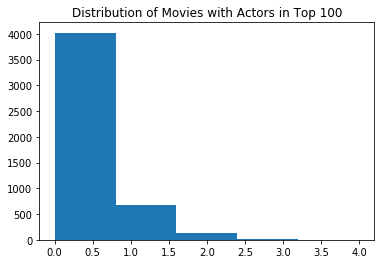

Text(0.5, 1.0, 'Distribution of Movies with Actors in Top 1000')

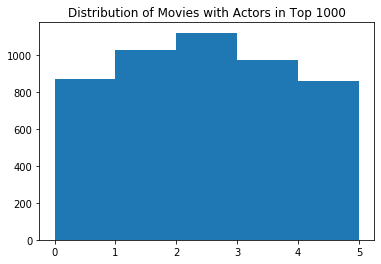

In [92]:
plt.hist(movies['top_100_actors'], bins=5)
plt.title('Distribution of Movies with Actors in Top 100')
plt.show()

plt.hist(movies['top_1000_actors'], bins=5)
plt.title('Distribution of Movies with Actors in Top 1000')

## Production Companies
I'll create a feature called 'top_pcs' which contains the number of top (most common) production companies involved in the movie.

In [93]:
# Create a list of production companies

PCs = movies.production_companies
pcs = []  # Each movie's production companies as a list, without the '|'
flatten_pcs = [] # All of the production companies as a single list

for list_of_pcs in PCs:
    movies_pcs = list_of_pcs.split('|')
    pcs.append(movies_pcs)
    for i in range(len(pcs)): #Traversing through the main list
        for j in range (len(pcs[i])): #Traversing through each sublist
            flatten_pcs.append(pcs[i][j]) #Appending elements into our flat_list
        


unique_pcs = set(flatten_pcs)
unique_pcs = list(unique_pcs)
print(len(unique_pcs))

3930


In [94]:
# Making the production_companies variable into lists
movies['production_companies'] = movies['production_companies'].apply(lambda x: x.split('|'))

In [95]:
print('First five unique production companies: ', unique_pcs[:5], '\n')
print('First five lists of production companies: ', pcs[:5], '\n')
print('First five elements of flatten_pcs: ', flatten_pcs[:5])
print('Length of flatten_pcs: ', len(flatten_pcs))

First five unique production companies:  ['Gold/Miller Productions', 'Corrino Media Corporation', 'Vinyl Films', 'Key Creatives', 'Blank of the Dead Productions'] 

First five lists of production companies:  [['Universal Studios', 'Amblin Entertainment', 'Legendary Pictures', 'Fuji Television Network', 'Dentsu'], ['Village Roadshow Pictures', 'Kennedy Miller Productions'], ['Summit Entertainment', 'Mandeville Films', 'Red Wagon Entertainment', 'NeoReel'], ['Lucasfilm', 'Truenorth Productions', 'Bad Robot'], ['Universal Pictures', 'Original Film', 'Media Rights Capital', 'Dentsu', 'One Race Films']] 

First five elements of flatten_pcs:  ['Universal Studios', 'Amblin Entertainment', 'Legendary Pictures', 'Fuji Television Network', 'Dentsu']
Length of flatten_pcs:  33558856


In [96]:
# Production companies frequency dictionary to obtain the biggest/most common companies
pc_freqdict = {}
pcs = tuple(pcs)

for companies in pcs:
    for company in companies:
        if company in pc_freqdict:
            pc_freqdict[company] += 1
        else:
            pc_freqdict[company] = 1
    
print(type(pc_freqdict.keys()))
sorted(pc_freqdict.keys())
top_pcs = []

for key in pc_freqdict.keys():
    if pc_freqdict[key] > 14:
        top_pcs.append(key)
        
print(len(top_pcs))

<class 'dict_keys'>
97


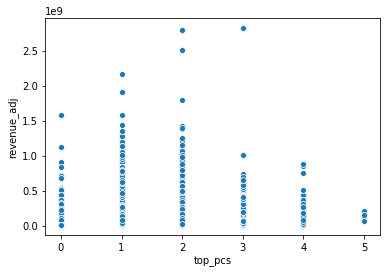

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


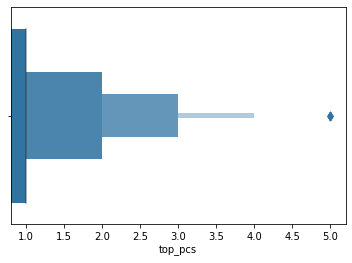

In [97]:
# Creating a new column called 'top_pcs' that will represent the number of top production companies 
# involved in a movie

movies['top_pcs'] = [len(set(i) & set(top_pcs)) for i in movies['production_companies']]
sns.scatterplot(x='top_pcs', y='revenue_adj', data=movies)
plt.show()

sns.boxenplot(x='top_pcs', data=movies)

## Book Film Adaptations
I'll import a list of books that have been adapted into movies and create a dummy variable, 'book_films', which will contain a one if the movie has been adapted from a book and a zero otherwise.

In [98]:
# Importing the book__film_adaptations 

book_film_adaptations = pd.read_csv('book_film_adaptations.csv')
book_films = pd.DataFrame(book_film_adaptations)


# Removing *s and years
book_films['Film_adaptation'] = book_films['Film_adaptation'].apply(lambda x: x.strip('*'))
book_films['Film_adaptation'] = book_films['Film_adaptation'].str.replace(u'\xa0', u' ')
titles_split = book_films['Film_adaptation'].str.split('(', n=1, expand=True)
book_films['Film_adaptation'] = titles_split[0]
book_films['Film_adaptation'] = book_films['Film_adaptation'].str.rstrip()
# book_films['Film_adaptation'] = book_films['Film_adaptation'].str.split('(')

# book_films['Film_adaptation'] = book_films['Film_adaptation'].apply(lambda x: x.split(' (', 1)[0])

# Converting the series to a list so we can compare it to the cast lists
book_films = book_films['Film_adaptation'].tolist()
print('\n Testing the list: ', book_films[72:77], '\n')

movies['books'] = [len(set(i) & set(book_films)) for i in movies['original_title']]
print('Number of movies adapted from books: \n', movies.books.value_counts())


 Testing the list:  ['Tom Sawyer', ' Huckleberry Finn', 'Tom Sawyer', 'The Adventures of Mark Twain', 'Back to Hannibal: The Return of Tom Sawyer and Huckleberry Finn'] 

Number of movies adapted from books: 
 0    4453
1     397
Name: books, dtype: int64


## Normalizing and Testing the Normality of the New Features
We can see that the T-values for the new features aren't terribly large.

In [99]:
# Normalizing new feature

movies['norm_winsorized_top_1000_actors'] = normalize(np.array(winsorize(movies['top_1000_actors'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)
movies['norm_winsorized_top_pcs'] = normalize(np.array(winsorize(movies['top_pcs'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)

features_to_test = ['norm_winsorized_top_1000_actors', 'top_1000_actors', 'norm_winsorized_top_pcs', 'top_pcs']

# Now run each and one of the featues in above list. Locate the features in your data and calculate the statistics. 
for feat in features_to_test:
    jb_stats = stats.jarque_bera(movies[feat])
    norm_stats = stats.normaltest(movies[feat])
    
    print("Testing for normality on {}:".format(feat))
    print('Jarque-Bera test statistics for', feat, 'is {0} and p value is {1}'.format(jb_stats[0], jb_stats[1]))
    print('Normality test statistics for', feat, 'is {0} and p value is {1}\n'.format(norm_stats[0], norm_stats[1]))

Testing for normality on norm_winsorized_top_1000_actors:
Jarque-Bera test statistics for norm_winsorized_top_1000_actors is 286.06397173290594 and p value is 0.0
Normality test statistics for norm_winsorized_top_1000_actors is 3744.63141370865 and p value is 0.0

Testing for normality on top_1000_actors:
Jarque-Bera test statistics for top_1000_actors is 198.86103705936537 and p value is 0.0
Normality test statistics for top_1000_actors is 627.2128337008916 and p value is 6.345468205764058e-137

Testing for normality on norm_winsorized_top_pcs:
Jarque-Bera test statistics for norm_winsorized_top_pcs is 212.08364306398863 and p value is 0.0
Normality test statistics for norm_winsorized_top_pcs is 1227.2586069587098 and p value is 3.1928577113487955e-267

Testing for normality on top_pcs:
Jarque-Bera test statistics for top_pcs is 893.8848855266674 and p value is 0.0
Normality test statistics for top_pcs is 602.2176034769197 and p value is 1.6986697483197553e-131



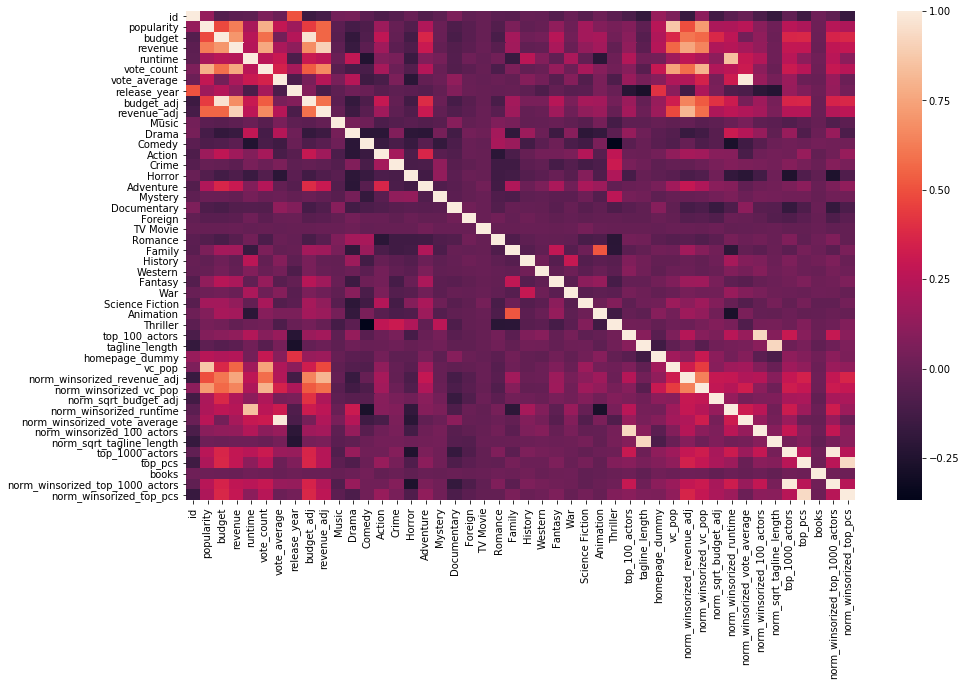

,norm_winsorized_revenue_adj
norm_winsorized_revenue_adj,1.000
revenue_adj,0.808
revenue,0.759
budget_adj,0.651
norm_winsorized_vc_pop,0.641
budget,0.607
vote_count,0.582
popularity,0.497
norm_winsorized_top_pcs,0.363
top_pcs,0.344


In [100]:
plt.figure(figsize=(15,9))
sns.heatmap(movies.corr())
plt.show()


movies.corr().loc[:, ["norm_winsorized_revenue_adj"]].sort_values(by='norm_winsorized_revenue_adj', ascending=False)

In [101]:
print(movies.describe())

              id  popularity        budget        revenue  runtime  \
count   4850.000    4850.000      4850.000       4850.000 4850.000   
mean   44575.001       1.045  29569700.632   89220658.325  107.965   
std    72361.406       1.357  40513434.965  162068389.382   21.113   
min        5.000       0.001         0.000          2.000   15.000   
25%     8286.000       0.388   1700000.000    7708081.250   95.000   
50%    12154.500       0.680  15000000.000   31826540.000  104.000   
75%    43956.500       1.210  40000000.000   99918234.250  117.000   
max   417859.000      32.986 425000000.000 2781505847.000  705.000   

       vote_count  vote_average  release_year    budget_adj    revenue_adj  \
count    4850.000      4850.000      4850.000      4850.000       4850.000   
mean      436.216         6.149      2000.922  35161017.182  115440772.436   
std       806.416         0.799        11.569  43756717.053  198790975.598   
min        10.000         2.100      1960.000         0.0

# Round 3 - Testing Our Models With Three New Variables

In [152]:
features3 = movies[['books','norm_winsorized_top_pcs','norm_winsorized_top_1000_actors', 'norm_sqrt_budget_adj',
                           'norm_winsorized_vc_pop','norm_winsorized_runtime','Adventure', 
                           'norm_winsorized_vote_average', 'Action', 'Family', 'Animation', 'Fantasy',
                           'homepage_dummy', 'Science Fiction', 'War', 'norm_sqrt_tagline_length', 'Western', 
                           'Thriller', 'History', 'TV Movie', 'Mystery', 'Comedy', 'Crime', 'Music', 
                           'Romance', 'Foreign', 'Horror', 'Documentary', 'release_year', 'Drama']]
X3_train, X3_test, Y3_train, Y3_test = train_test_split(features3, target, test_size = .3, random_state = 465)

X3_train_const = sm.add_constant(X3_train)
X3_test_const = sm.add_constant(X3_test)

## OLS

The OLS continues to perform well with a small MSE of 5.306e-05 with cross validation.

In [153]:
print("The number of observations in training set is {}".format(X3_train.shape[0]))
print("The number of observations in test set is {}".format(X3_test.shape[0]))

# We fit an OLS model using sklearn
ols = LinearRegression().fit(X3_train_const, Y3_train)

results_train = sm.OLS(Y3_train, X3_train_const).fit()
results_test = sm.OLS(Y3_test, X3_test_const).fit()
# We print the summary results
print(results_train.summary())
print('\n')
print(results_test.summary())
print('\n')

# We are making predictions here
Y3_preds_train = ols.predict(X3_train_const)
Y3_preds_test = ols.predict(X3_test_const)


print("R-squared of the model on the training set is: {}".format(ols.score(X3_train_const, Y3_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ols.score(X3_test_const, Y3_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y3_test, Y3_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y3_test, Y3_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y3_test, Y3_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y3_test - Y3_preds_test) / Y3_test)) * 100))

The number of observations in training set is 3395
The number of observations in test set is 1455
                                 OLS Regression Results                                
Dep. Variable:     norm_winsorized_revenue_adj   R-squared:                       0.586
Model:                                     OLS   Adj. R-squared:                  0.583
Method:                          Least Squares   F-statistic:                     158.9
Date:                         Thu, 26 Dec 2019   Prob (F-statistic):               0.00
Time:                                 20:17:00   Log-Likelihood:                 12069.
No. Observations:                         3395   AIC:                        -2.408e+04
Df Residuals:                             3364   BIC:                        -2.389e+04
Df Model:                                   30                                         
Covariance Type:                     nonrobust                                         
                      

## OLS with Cross Validation
R-squared of 0.562, still very low MSE.

In [154]:
cross_val_scores = cross_val_score(LinearRegression(), features3, target, cv=10)
nmse_cross_val_scores = cross_val_score(LinearRegression(), features3, target, cv=10, scoring='neg_mean_squared_error')
print('OLS R-Squared Score: ', cross_val_scores.mean())
print('R-Squared Scores with Cross Validation: ', cross_val_scores)
print('\n')
print('Negative MSE Score: ', nmse_cross_val_scores.mean())
print('Negative MSE Scores with Cross Validation: ', nmse_cross_val_scores)

OLS R-Squared Score:  0.5622811475359933
R-Squared Scores with Cross Validation:  [0.61426509 0.61309457 0.65949892 0.6435998  0.61351174 0.60826785
 0.62852407 0.43367024 0.42624624 0.38213295]


Negative MSE Score:  -5.0663260333748177e-05
Negative MSE Scores with Cross Validation:  [-5.16101065e-05 -4.46443956e-05 -3.77504037e-05 -4.32349928e-05
 -4.67306863e-05 -3.37008156e-05 -3.97826905e-05 -6.57209135e-05
 -6.26063686e-05 -8.08512301e-05]


## Lasso with Cross Validation

While the Lasso had one of the lower MSEs in the first round, it continues to be outperformed by the OLS model with an MSE of 5.6521e-05.

In [155]:
lasso_gsc = GridSearchCV(
        estimator=LassoCV(),
        param_grid={
            'eps': [0.001, 0.001, 0.1, 1]},
#             'n_alphas': [0, 1, 10]},
        cv=10, scoring='r2', verbose=1, n_jobs=-1)

grid_result = lasso_gsc.fit(features3, target)
best_params = grid_result.best_params_
# svr_gsc.best_estimator_
best_lasso = LassoCV(eps=best_params['eps'], verbose=False)
# n_alphas=best_params['n_alphas'],
print('Parameters for the best Lasso model: ', best_lasso)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Parameters for the best Lasso model:  LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.8s finished


In [156]:
print('Lasso Regression with Cross Validation:')
lassoregrCV = LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

lassoregrCV.fit(features3, target)

# We are making predictions here
Y3_preds = lassoregrCV.predict(features3)


print('Lasso Cross Validation Outcomes:')
print("-----Test set statistics-----")
print("R-squared of the model is: {}".format(lassoregrCV.score(features3, target)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(target, Y3_preds)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(target, Y3_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(target, Y3_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((target - Y3_preds) / target)) * 100))

Lasso Regression with Cross Validation:
Lasso Cross Validation Outcomes:
-----Test set statistics-----
R-squared of the model is: 0.513448452209254
Mean absolute error of the prediction is: 0.00569649949389065
Mean squared error of the prediction is: 5.652087370283666e-05
Root mean squared error of the prediction is: 0.007518036559025013
Mean absolute percentage error of the prediction is: inf


## Ridge Regression with Cross Validation
A slight improvement on the Ridge model from the last round of features.

In [157]:
ridgeCV.fit(features3, target)

# We are making predictions here
Y3_preds = ridgeCV.predict(features3)


print("-----Test set statistics-----")
print("R-squared of the model is: {}".format(ridgeCV.score(features3, target)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(target, Y3_preds)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(target, Y3_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(target, Y3_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((target - Y3_preds) / target)) * 100))

-----Test set statistics-----
R-squared of the model is: 0.5579374810752733
Mean absolute error of the prediction is: 0.005344155554841823
Mean squared error of the prediction is: 5.135274959940747e-05
Root mean squared error of the prediction is: 0.007166083281640499
Mean absolute percentage error of the prediction is: inf


## ElasticNet with Cross Validation

In [155]:
# Using GridSearchCV to find the best parameters for the ElasticNEt
en_gsc = GridSearchCV(
        estimator=ElasticNetCV(),
        param_grid={'l1_ratio': [0.1, 0.3, 0.7, 1],
                   'eps': [0.001, .01, .1, 1],
                    'n_alphas': [50, 100, 200]}, verbose=1)
#                     ,
grid_result = en_gsc.fit(features3, target)
best_params = grid_result.best_params_
best_en = ElasticNetCV(l1_ratio=best_params['l1_ratio'])

print('Parameters for the best ElasticNet Model: ', best_en)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Parameters for the best ElasticNet Model:  ElasticNetCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
             l1_ratio=1, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0)


[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:   41.4s finished


In [158]:
elasticregrCV = ElasticNetCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
             l1_ratio=1, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0) 
elasticregrCV.fit(features3, target)

# We are making predictions here
Y3_preds = elasticregrCV.predict(features3)

print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregrCV.score(features3, target)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(target, Y3_preds)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(target, Y3_preds)))
print("Root mean squared error of the prediction is: {}".format(sqrt(mean_squared_error(target, Y3_preds))))
print("Root mean squared error of the prediction is: {}".format(rmse(target, Y3_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((target - Y3_preds) / target))))

-----Test set statistics-----
R-squared of the model on the test set is: 0.513448452209254
Mean absolute error of the prediction is: 0.00569649949389065
Mean squared error of the prediction is: 5.652087370283666e-05
Root mean squared error of the prediction is: 0.007518036559025013
Root mean squared error of the prediction is: 0.007518036559025013
Mean absolute percentage error of the prediction is: inf


## Random Forests
While slightly better than the last Random Forest model, I wouldn't say it's significant.

In [87]:
rf_gsc = GridSearchCV(
        estimator=ensemble.RandomForestRegressor(),
        param_grid={
            'max_depth': [80, 100, 120],
            'max_features': [2, 3],
            'min_samples_leaf': [3, 4, 5],
            'min_samples_split': [8, 10, 12],
            'n_estimators': [100, 500, 1000]
        },
        cv=10, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

rf_gsc.fit(features3, target)
best_params = rf_gsc.best_params_
# svr_gsc.best_estimator_
best_rf = ensemble.RandomForestRegressor(max_depth=best_params['max_depth'], max_features=best_params["max_features"],
                                         min_samples_leaf=best_params["min_samples_leaf"], min_samples_split=best_params["min_samples_split"],
                                         n_estimators=best_params['n_estimators'],verbose=False)

print('Parameters for the best Support Vector Model: ', best_rf)

Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 32.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 57.0min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed: 58.6min finished


Parameters for the best Support Vector Model:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=12,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=False, warm_start=False)


In [159]:
rfr = ensemble.RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=12,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=False, warm_start=False)

cross_val_scores = cross_val_score(rfr, features3, target, cv=10, verbose=1)
nmse_cross_val_score = cross_val_score(rfr, features3, target, cv=10, verbose=1, scoring='neg_mean_squared_error')
print('Mean R-Squared: ', cross_val_scores.mean())
print('Cross Validation Scores: ', cross_val_scores)
print('\n')
print('Mean Negative MSE: ', nmse_cross_val_score.mean())
print('Cross Validation MSE Scores: ', nmse_cross_val_score)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean R-Squared:  0.6548192171207574
Cross Validation Scores:  [0.7070523  0.69551908 0.71802612 0.70031057 0.70294305 0.71798273
 0.6702713  0.62275352 0.58056293 0.43277056]


Mean Negative MSE:  -4.0229205193855014e-05
Cross Validation MSE Scores:  [-3.99946353e-05 -3.53342309e-05 -3.11076610e-05 -3.63059109e-05
 -3.60856300e-05 -2.41661822e-05 -3.51383895e-05 -4.36525104e-05
 -4.61198399e-05 -7.43870619e-05]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.3s finished


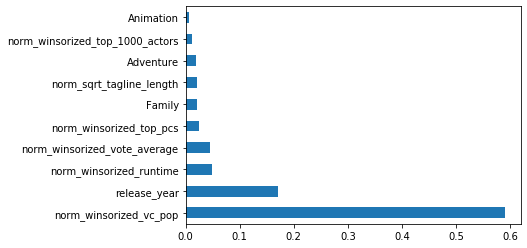

In [160]:
rfr.fit(features3, target)
feat_importances = pd.Series(rfr.feature_importances_, index=features3.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

## Gradient Boosting
While the discrepancy between the R-squareds in the training and tests sets differ greatly, the R-squared for the test set for the Gradient Boosting model is much better than the OLS, Ride, and ElasticNet models. However, the previous set of features produced a slightly higher R-squared and lower evaluation metrics.

In [394]:

# Using GridSearchCV to find the best parameters for the Gradient Boosting
gbr_gsc = GridSearchCV(
        estimator= ensemble.GradientBoostingRegressor(loss='ls'),
        param_grid={
            'learning_rate': [0.001, 0.01, 0.1, 1],
            'n_estimators': [800, 1000, 1500, 2000],
            'max_depth': [3, 4, 5]
        },
        cv=10, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

grid_result = gbr_gsc.fit(features3, target)
best_params = grid_result.best_params_
best_gbr = ensemble.GradientBoostingRegressor(learning_rate=best_params['learning_rate'], n_estimators=best_params['n_estimators'], 
                    max_depth=best_params['max_depth'],  tol=0.001)
print('Best parameters for Gradient Boosting Model: ', best_gbr)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 31.2min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 35.2min finished


Best parameters for Gradient Boosting Model:  GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [161]:
cross_val_scores = cross_val_score(best_gbr, features3, target, cv=10, verbose=1)
nmse_cross_val_score = cross_val_score(best_gbr, features3, target, cv=10, verbose=1, scoring='neg_mean_squared_error')
print('Mean R-Squared: ', cross_val_scores.mean())
print('Cross Validation Scores: ', cross_val_scores)
print('\n')
print('Mean Negative MSE: ', nmse_cross_val_score.mean())
print('Cross Validation MSE Scores: ', nmse_cross_val_score)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   50.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean R-Squared:  0.6712485580690898
Cross Validation Scores:  [0.72781378 0.69309464 0.72171255 0.72188319 0.70842008 0.72172644
 0.68850091 0.63479161 0.59369574 0.50084665]


Mean Negative MSE:  -3.809170377959295e-05
Cross Validation MSE Scores:  [-3.64181317e-05 -3.54174686e-05 -3.08303174e-05 -3.36837889e-05
 -3.52552237e-05 -2.39399443e-05 -3.33595559e-05 -4.23814115e-05
 -4.43347583e-05 -6.52964376e-05]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   49.5s finished


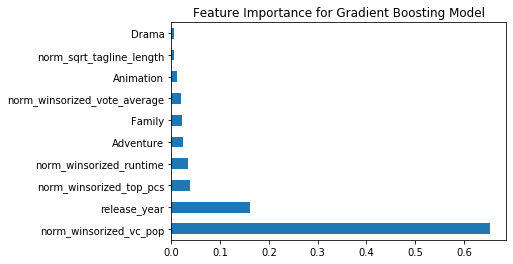

In [164]:
best_gbr.fit(features3, target)
feat_importances = pd.Series(best_gbr.feature_importances_, index=features3.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importance for Gradient Boosting Model')
plt.show()

## XGBoost

In [207]:
gbm_param_grid = {
    'learning_rate': [0.01, 0.1, 0.3, 0.5],
     'colsample_bytree': np.linspace(0.3, 0.5, 0.9),
     'n_estimators': [25, 50, 100],
     'max_depth': [5, 10, 20],
    'objective' : ['reg:squarederror']
}

gbm = xgb.XGBRegressor()

grid_mse = GridSearchCV(estimator = gbm, param_grid = gbm_param_grid, scoring = 'neg_mean_squared_error', cv = 10, verbose = 1)

grid_mse.fit(X3_train, Y3_train)

print("Best parameters found: ",grid_mse.best_params_)
print("Lowest MSE found: ", np.abs3grid_mse.best_score_)

Fitting 10 folds for each of 900 candidates, totalling 9000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 9000 out of 9000 | elapsed: 557.0min finished


Best parameters found:  {'colsample_bytree': 0.9, 'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 50, 'objective': 'reg:squarederror'}
Lowest MSE found:  1.6500402028813206e+16


In [166]:
xg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.9, learning_rate = 0.1,
                max_depth = 5, n_estimators=100)

xg.fit(features3, target)
cross_val_scores = cross_val_score(xg, features3, target, cv=10)
nmse_cross_val_scores = cross_val_score(xg, features3, target, cv=10, scoring='neg_mean_squared_error')
print('XGBoost Score: ', xg.score(features3, target))
print('XGBoost mean of R-squared array: ', cross_val_scores.mean())
print('XGBoost R-squared array: ', cross_val_scores)
print('XGBoost Mean MSE: ', nmse_cross_val_score.mean())
print('XGBoost Negative MSE array: ', cross_val_score(xg, features3, target, cv=10, scoring='neg_mean_squared_error'))


XGBoost Score:  0.8043887881877746
XGBoost mean of R-squared array:  0.6729376701823908
XGBoost R-squared array:  [0.72240622 0.69335433 0.71716093 0.72816097 0.73096783 0.71918792
 0.70159047 0.63612716 0.6037144  0.47670647]
XGBoost Mean MSE:  -3.809170377959295e-05
XGBoost Negative MSE array:  [-3.71411658e-05 -3.53833507e-05 -3.13575778e-05 -3.29768569e-05
 -3.25289517e-05 -2.41583343e-05 -3.19577479e-05 -4.22263803e-05
 -4.32415508e-05 -6.84757758e-05]


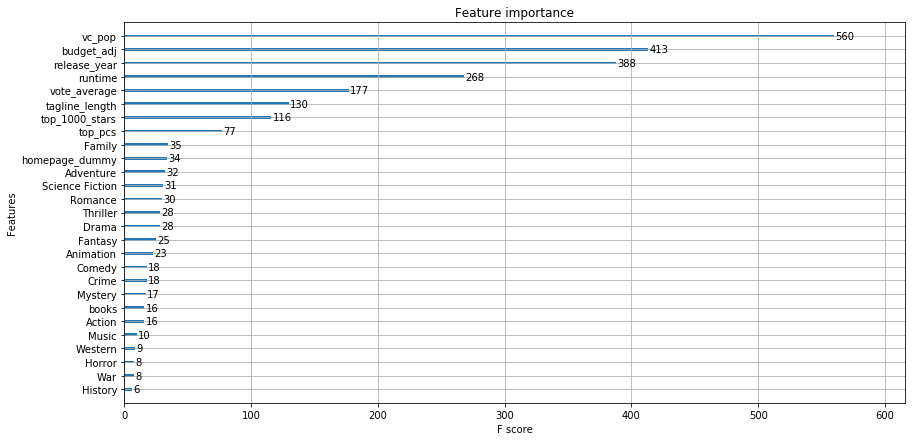

In [341]:
xgb.plot_importance(xg)
plt.rcParams['figure.figsize'] = (17,7)

## Summary of Third Round 

|Model | R-Squared Value |Mean Squared Error
------|------|------|
|OLS  |0.562 | 5.066e-05
|Lasso Regression |0.513| 5.652e-05|  
|Ridge Regression |0.558 |5.135e-05
|ElasticNet |0.513 | 5.652e-05
|Random Forests |0.655 | 4.023e-05
|Gradient Boosting|0.671 |3.809e-05
|XGBoost|0.673| 3.714e-05 


## Summary
To recall, the goal of this project was to predict the success of a movie with the given information using the adjusted revenue of a movie as the metric of success. While I started with nearly 11,000 movies, I immediately had to cut 6,000 as they did not have information for the target variable. I cleaned the data, transformed the features for the linear regression models, and ran seven different types of models on the data using three different sets of features.

# Conclusions

The ensemble models performed better in all three rounds of testing, with the Gradient Boosting model performing best in the first two rounds and XGBoost in the last. 

In all models, the vote count/popularity feature I created at the beginning of the project is in the top three most important features. It's fairly intuitive that vc_pop would have a large impact on the success of a movie as this feature represents the popularity a movie has and the representation it receives - the more people who know about and are interested in a movie, the more people will see it, the larger its revenue stream. The release year also tended to have a big effect, as did the runtime (the length of a movie in minutes). I find it very curious that runtime has such a strong effect - the longer the movie, the higher the adjusted revenue. It could be that a longer movie is able to tell a story in more depth, or that people simply feel that they get more bang for their buck. It could also be that longer movies are highly correlated with other variables that indicate a highly successful movie. Both random forests and the gradient boosting models had runtime as fairly important features (third and fifth), so I don't believe it's an error, but I would like to look into it in more depth.

# Further Investigation

I'd be interested to analyze this dateset with the following information to see if I can increase the performance of the model:

- Budget breakdown (specifically Marketing/commercial budget)
- Month of release
- Theatres vs. straight to DVD vs. Netflix
- Cast diversity

This was a really interesting project and I'd love to continue it when I have time. 